# 1. Environment Setup


In [1]:
import json
import torch
import numpy as np
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pathlib import Path
from types import SimpleNamespace
from importlib import import_module
import random

%matplotlib inline

In [2]:
from senn.models.losses import *
from senn.models.parameterizers import *
from senn.models.conceptizers import *
from senn.models.aggregators import *
from senn.models.senn import SENN, DiSENN

In [3]:
from senn.datasets.dataloaders import get_dataloader
from senn.utils.plot_utils import show_explainations, show_prototypes, plot_lambda_accuracy, get_comparison_plot

In [4]:
from rotation import rotate_resize_and_cast, rotate_image

## Utility functions

In [5]:
def get_config(filename):
    config_path = Path('configs')
    config_file = config_path / filename
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    return SimpleNamespace(**config)

In [6]:
def load_checkpoint(config):
    model_file = Path('results') / config.exp_name / "checkpoints" / "best_model.pt" 
    return torch.load(model_file, config.device)

In [7]:
def accuracy(model, dataloader, config):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for i, (x, labels) in enumerate(dataloader):
            x = x.float().to(config.device)
            labels = labels.long().to(config.device)
            y_pred, (concepts, relevances), _ = model(x)
            accuracies.append((y_pred.argmax(axis=1) == labels).float().mean().item())
    accuracy = np.array(accuracies).mean()
    print(f"Test Mean Accuracy: {accuracy * 100: .3f} %")

## Config

In [8]:
plt.style.use('seaborn-v0_8-paper')

# 2. Basic Comparisons

In [9]:
mnist_config = get_config("mnist_lambda1e-4_seed29.json")
mnist_config.device = "cpu"

In [10]:
_, _, mnist_test_dl = get_dataloader(mnist_config)

In [11]:
conceptizer = ConvConceptizer(**mnist_config.__dict__)
parameterizer = ConvParameterizer(**mnist_config.__dict__)
aggregator = SumAggregator(**mnist_config.__dict__)

mnist_SENN = SENN(conceptizer, parameterizer, aggregator)

In [12]:
mnist_checkpoint = load_checkpoint(mnist_config)
mnist_SENN.load_state_dict(mnist_checkpoint['model_state'])

/var/folders/7s/51n924ds2p15l54wx1p9dwm80000gn/T/ipykernel_14922/3168636641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_file, config.device)


<All keys matched successfully>

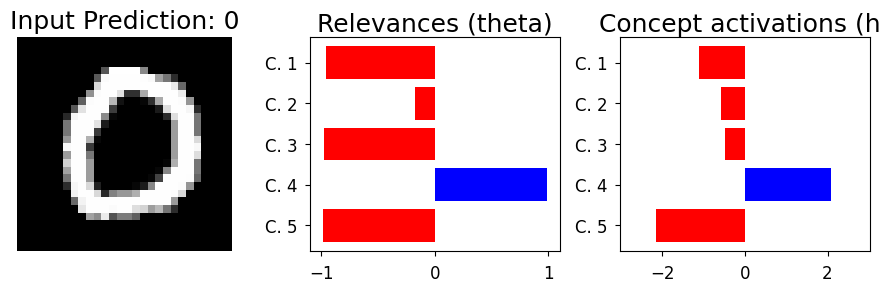

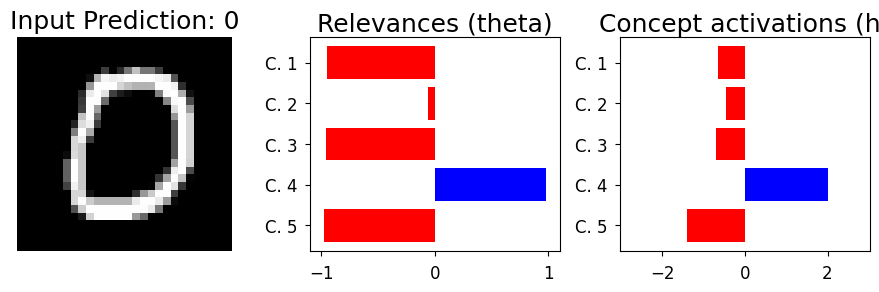

In [13]:
show_explainations(mnist_SENN, mnist_test_dl, 'mnist')

In [14]:
# Imports
import json
from os import path
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import cv2

from rotation import rotate_resize_and_cast

from senn.utils.plot_utils import (
    create_barplot,
    plot_lambda_accuracy,
    show_explainations
)

plt.style.use('seaborn-v0_8-paper')

def show_explanation_with_rotation(model, image, x_rotation=0, y_rotation=0, z_rotation=0, save_path=None):
    """Shows SENN explanations for original and rotated versions of an image."""
    device = 'cuda:0' if next(model.parameters()).is_cuda else 'cpu'
    model.eval()

    # ORIGINAL
    # Prepare original image
    # original_img = image.unsqueeze(0).float().to(device)
    
    # # Create rotated version
    # image_np = image.squeeze().cpu().numpy()
    # image_bgr = cv2.merge([image_np] * 3)
    # _, rotated_canvas = rotate_resize_and_cast(
    #     image_bgr, 
    #     x_rotation=x_rotation,
    #     y_rotation=y_rotation,
    #     z_rotation=z_rotation
    # )
    # rotated_tensor = torch.tensor(rotated_canvas[:,:,0]).unsqueeze(0).float().to(device)
    original_img = image
    
    print(f"Original image dtype: {image.dtype}")
    print(f"Original image range: {image.min().item()}-{image.max().item()}")
    
    image_np = image.squeeze().cpu().numpy()
    print(f"After numpy conversion dtype: {image_np.dtype}")
    print(f"Numpy range: {image_np.min()}-{image_np.max()}")
    
    image_bgr = cv2.merge([image_np] * 3)
    print(f"After BGR merge dtype: {image_bgr.dtype}")
    print(f"BGR range: {image_bgr.min()}-{image_bgr.max()}")
    
    _, rotated_canvas = rotate_resize_and_cast(
        image_bgr, 
        x_rotation=x_rotation,
        y_rotation=y_rotation,
        z_rotation=z_rotation
    )
    rotated_tensor = torch.tensor(rotated_canvas[:,:,0]).unsqueeze(0).float().to(device)
    
    # Get SENN explanations for both
    with torch.no_grad():
        y_pred_orig, (concepts_orig, relevances_orig), _ = model(original_img)
        y_pred_rot, (concepts_rot, relevances_rot), _ = model(rotated_tensor)
    
    if len(y_pred_orig.size()) > 1:
        y_pred_orig = y_pred_orig.argmax(1)
        y_pred_rot = y_pred_rot.argmax(1)
    
    # Get concept limits for consistent plotting
    concepts = torch.cat([concepts_orig, concepts_rot])
    concepts_min = concepts.min().item()
    concepts_max = concepts.max().item()
    concept_lim = max(abs(concepts_min), abs(concepts_max))
    
    # Create figure
    fig = plt.figure(figsize=(15, 6))
    gridsize = (2, 3)
    
    # Original image and its explanations
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (0, 2))
    
    # Rotated image and its explanations
    ax4 = plt.subplot2grid(gridsize, (1, 0))
    ax5 = plt.subplot2grid(gridsize, (1, 1))
    ax6 = plt.subplot2grid(gridsize, (1, 2))
    
    # Plot original image and explanations
    ax1.imshow(original_img.squeeze().cpu(), cmap='gray')
    ax1.set_axis_off()
    ax1.set_title(f'Original - Pred: {y_pred_orig.item()}', fontsize=12)
    
    create_barplot(ax2, relevances_orig[0], y_pred_orig[0], x_label='Relevances (θ)')
    ax2.xaxis.set_label_position('top')
    ax2.tick_params(which='major', labelsize=10)
    
    create_barplot(ax3, concepts_orig[0], y_pred_orig[0], 
                  x_lim=concept_lim, x_label='Concepts (h)')
    ax3.xaxis.set_label_position('top')
    ax3.tick_params(which='major', labelsize=10)
    
    # Plot rotated image and explanations
    ax4.imshow(rotated_canvas[:,:,0], cmap='gray')  # Display directly from the OpenCV output
    ax4.set_axis_off()
    ax4.set_title(f'Rotated ({x_rotation}°,{y_rotation}°,{z_rotation}°) - Pred: {y_pred_rot.item()}', fontsize=12)
    
    create_barplot(ax5, relevances_rot[0], y_pred_rot[0], x_label='Relevances (θ)')
    ax5.tick_params(which='major', labelsize=10)
    
    create_barplot(ax6, concepts_rot[0], y_pred_rot[0], 
                  x_lim=concept_lim, x_label='Concepts (h)')
    ax6.tick_params(which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    plt.close('all')


Minor Rotations
--------------------------------------------------

X-Axis Rotations

X-Rotation Example 1/5 (angle: -3°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


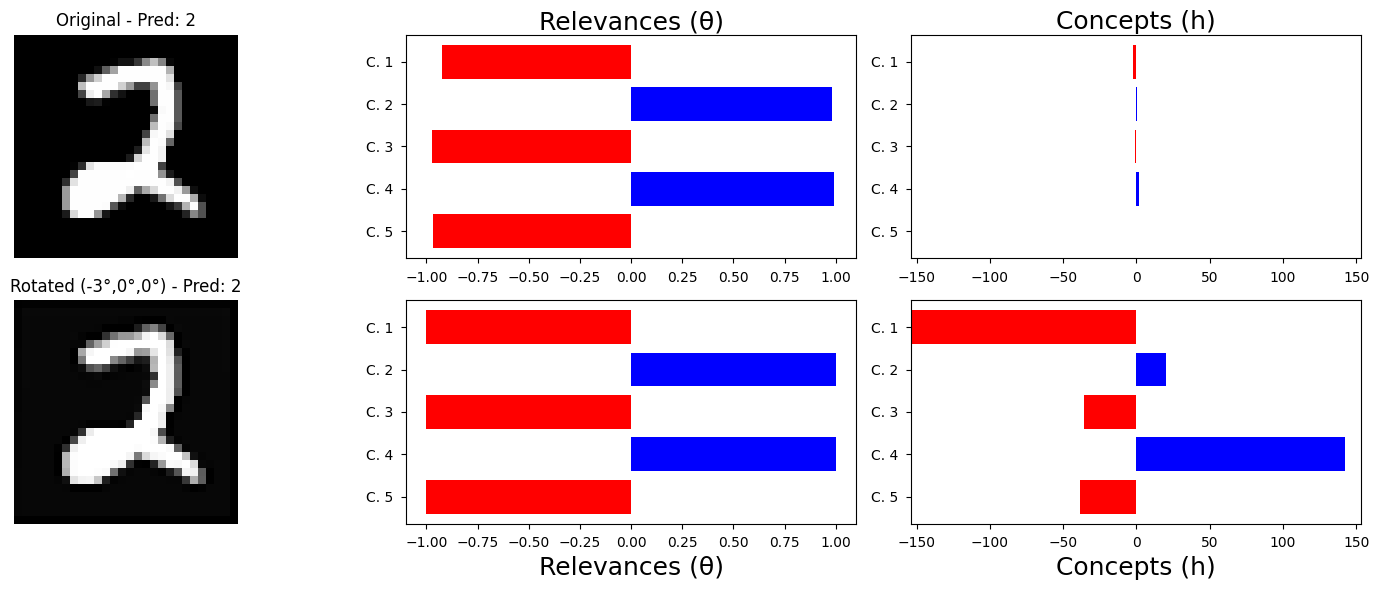


X-Rotation Example 2/5 (angle: -20°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


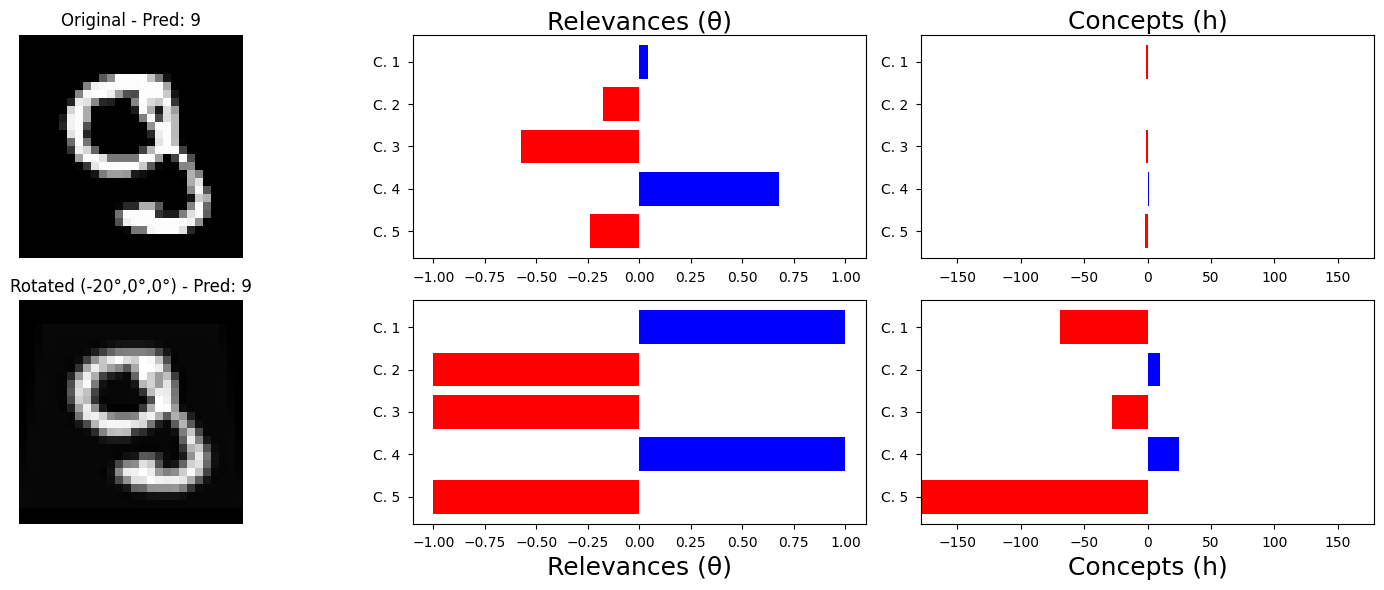


X-Rotation Example 3/5 (angle: 10°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


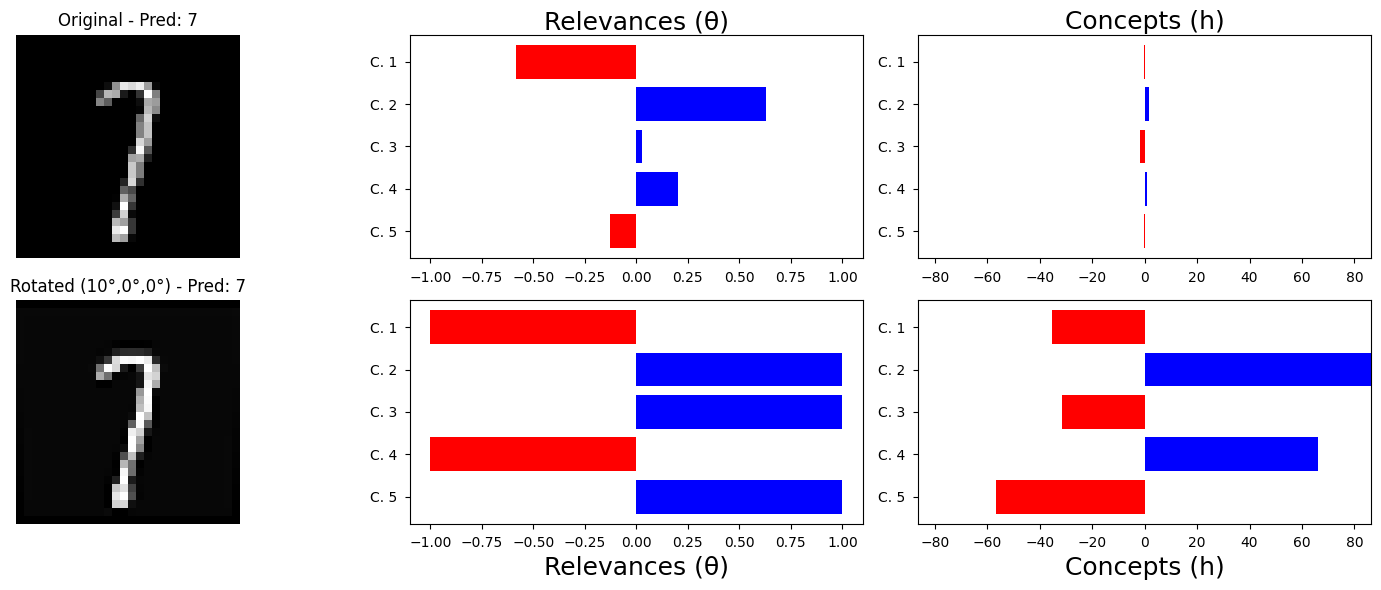


X-Rotation Example 4/5 (angle: -22°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


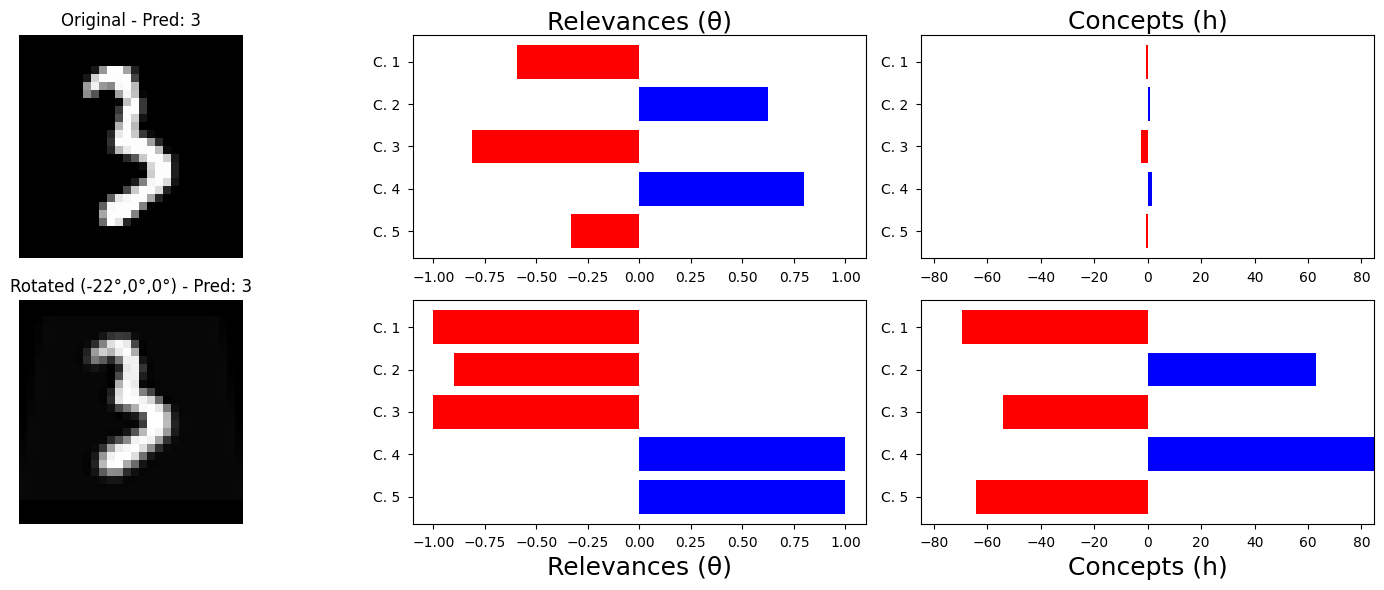


X-Rotation Example 5/5 (angle: -12°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.808758497238159
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.808758497238159
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.808758497238159


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


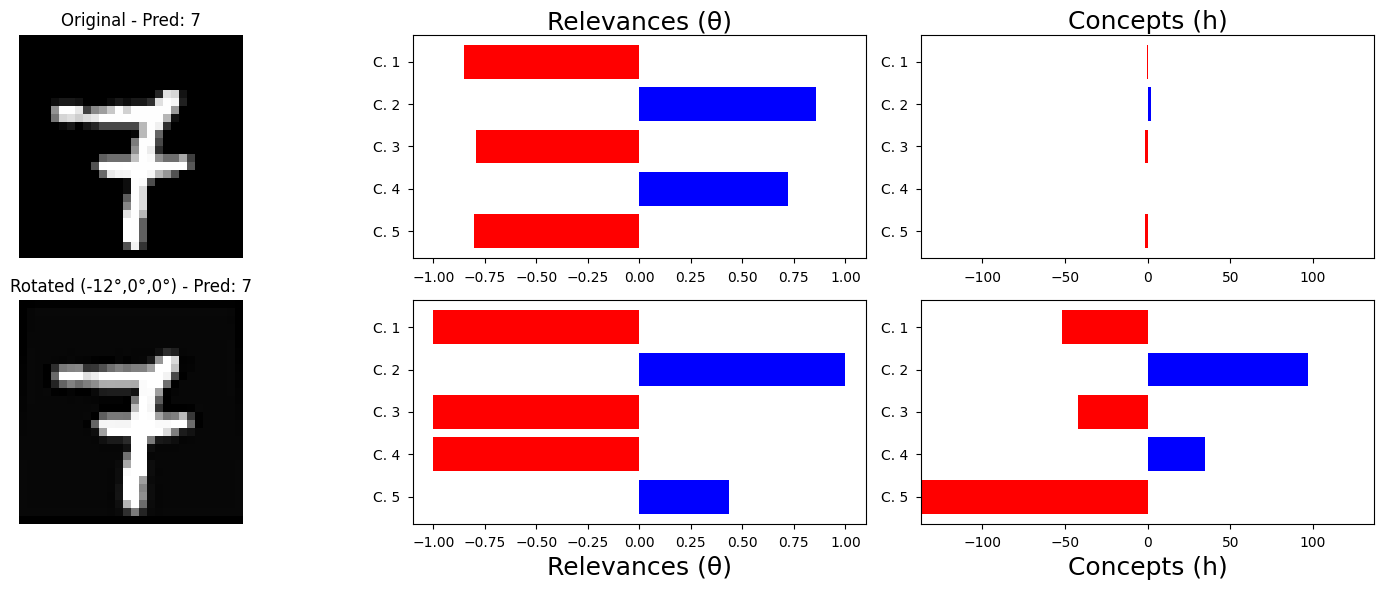


Y-Axis Rotations

Y-Rotation Example 1/5 (angle: 6°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


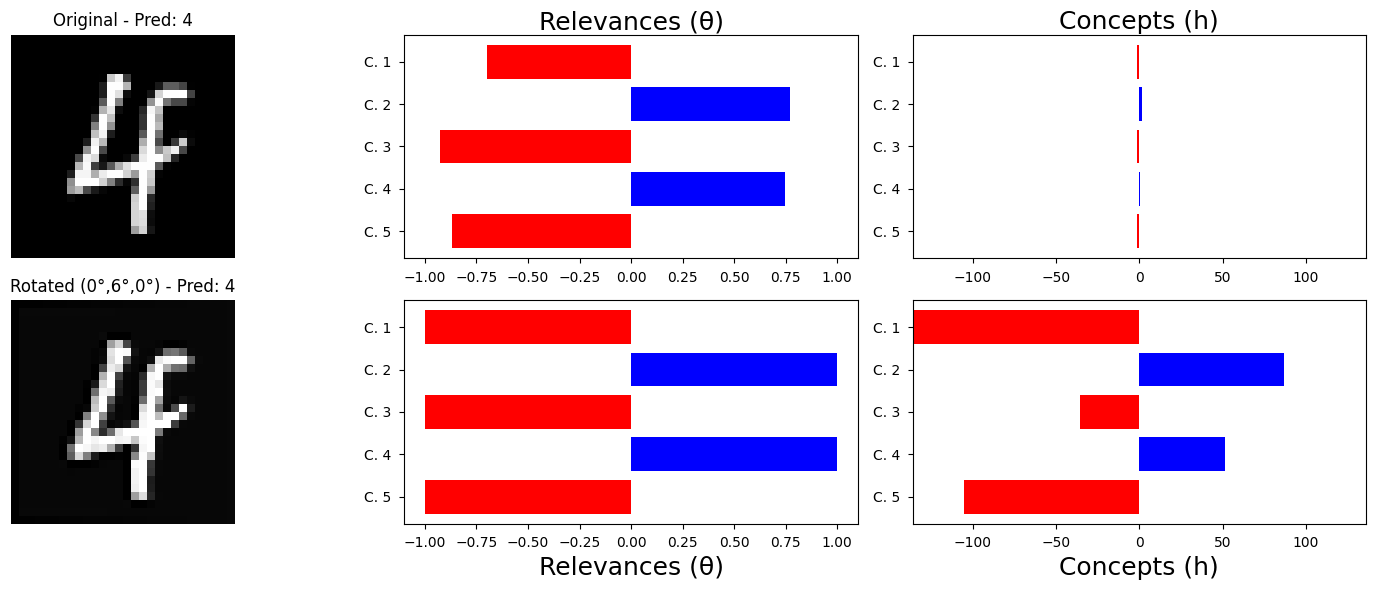


Y-Rotation Example 2/5 (angle: -30°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


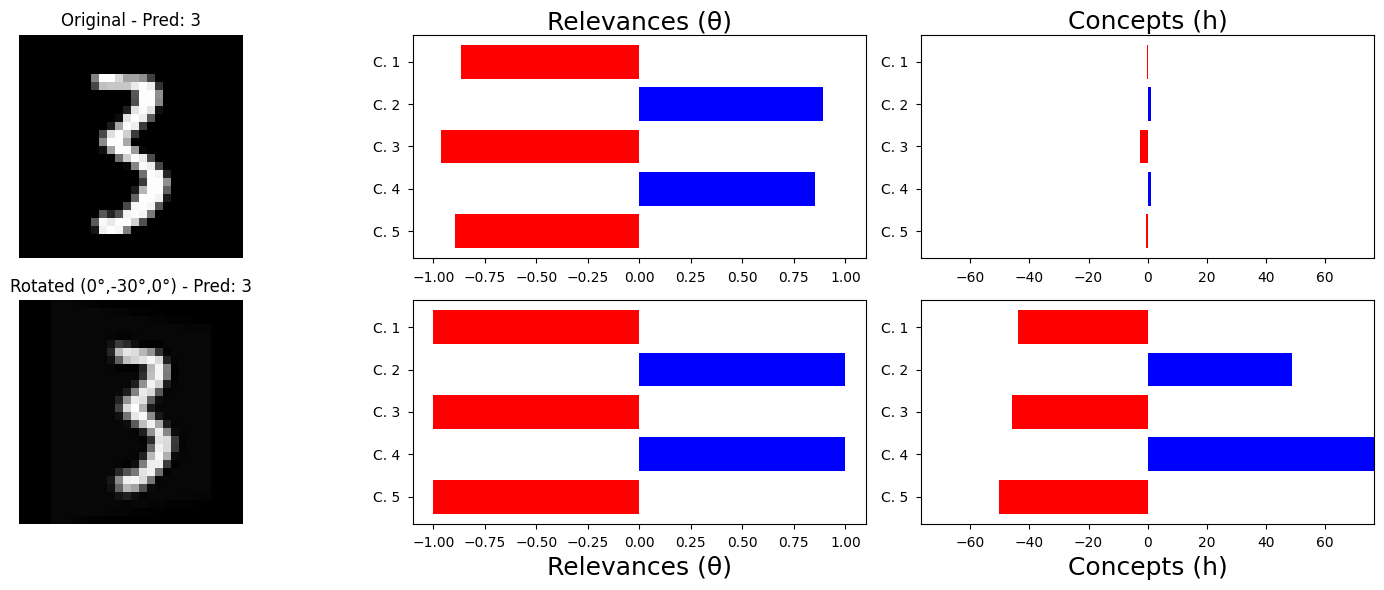


Y-Rotation Example 3/5 (angle: -16°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


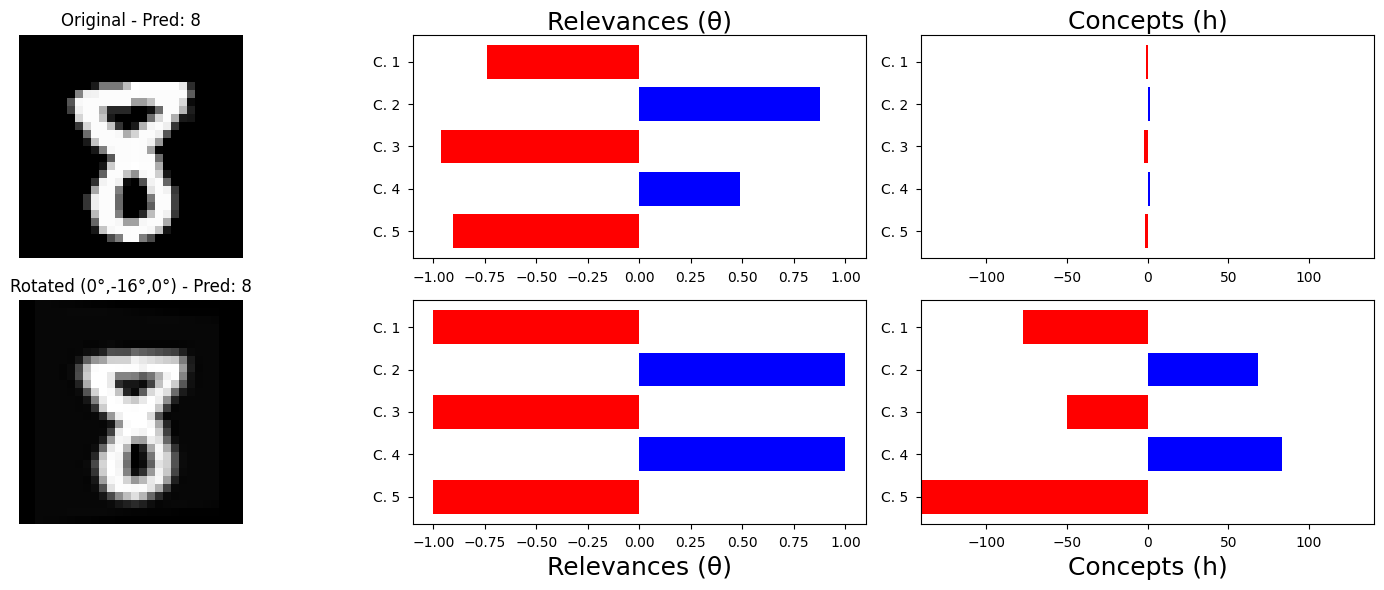


Y-Rotation Example 4/5 (angle: 13°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


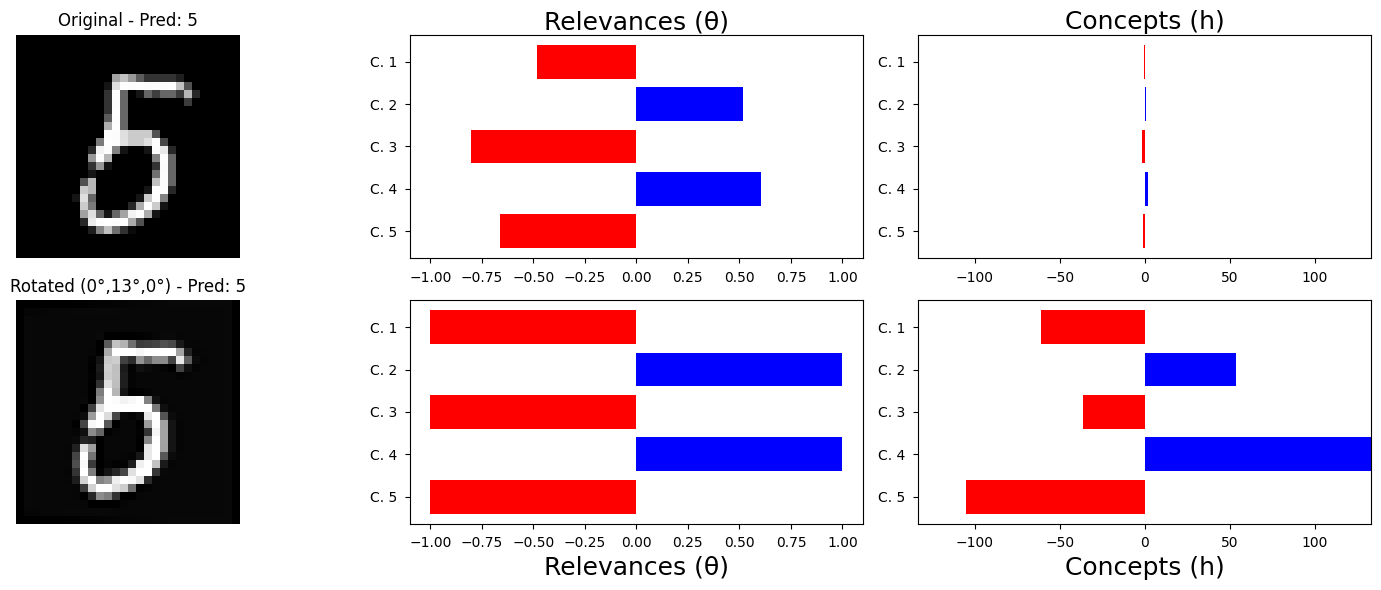


Y-Rotation Example 5/5 (angle: 6°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


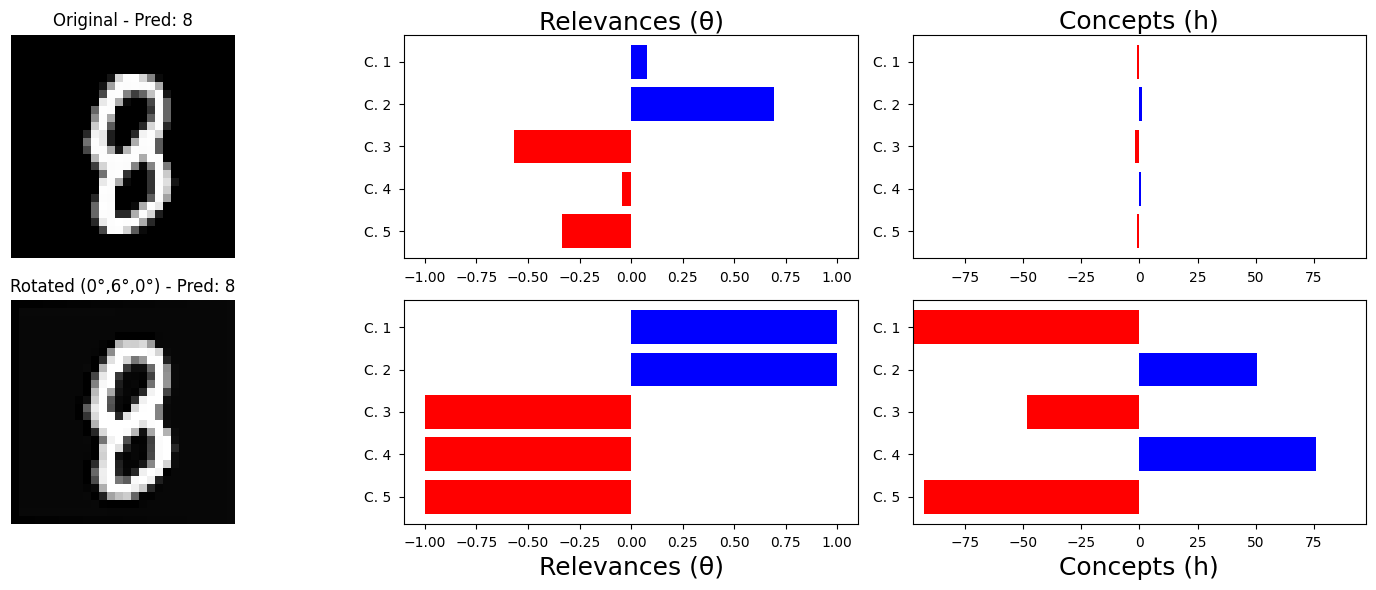


Z-Axis Rotations

Z-Rotation Example 1/5 (angle: -21°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


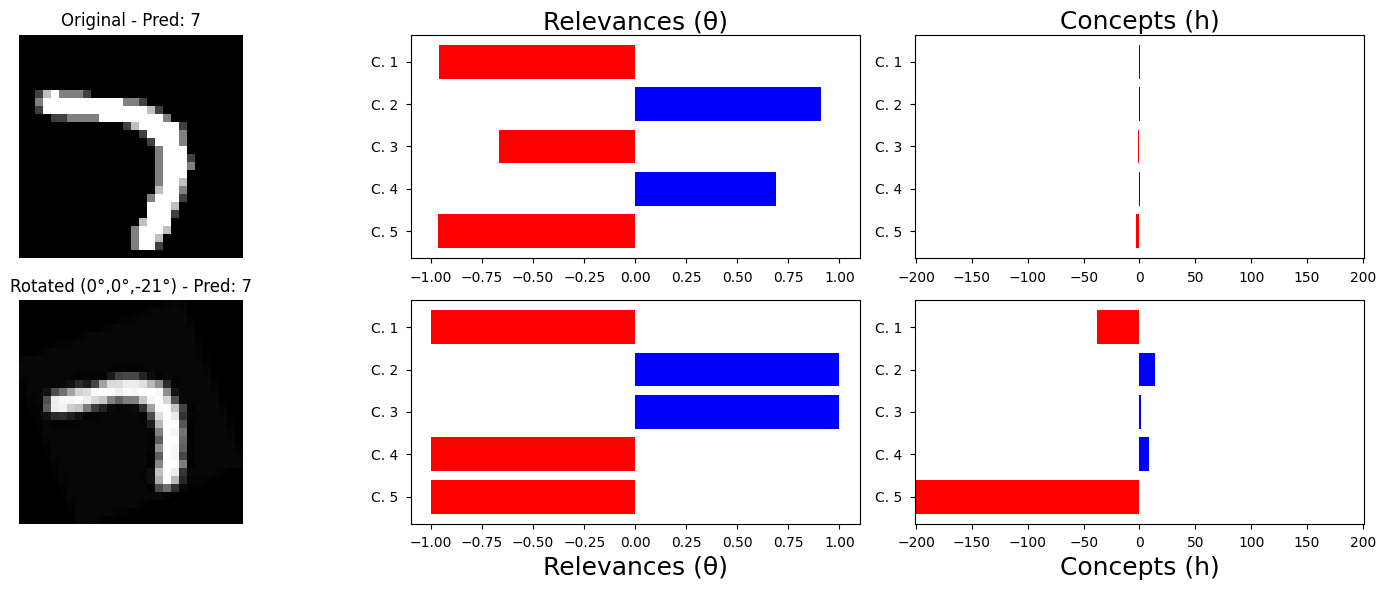


Z-Rotation Example 2/5 (angle: -30°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.808758497238159
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.808758497238159
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.808758497238159


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


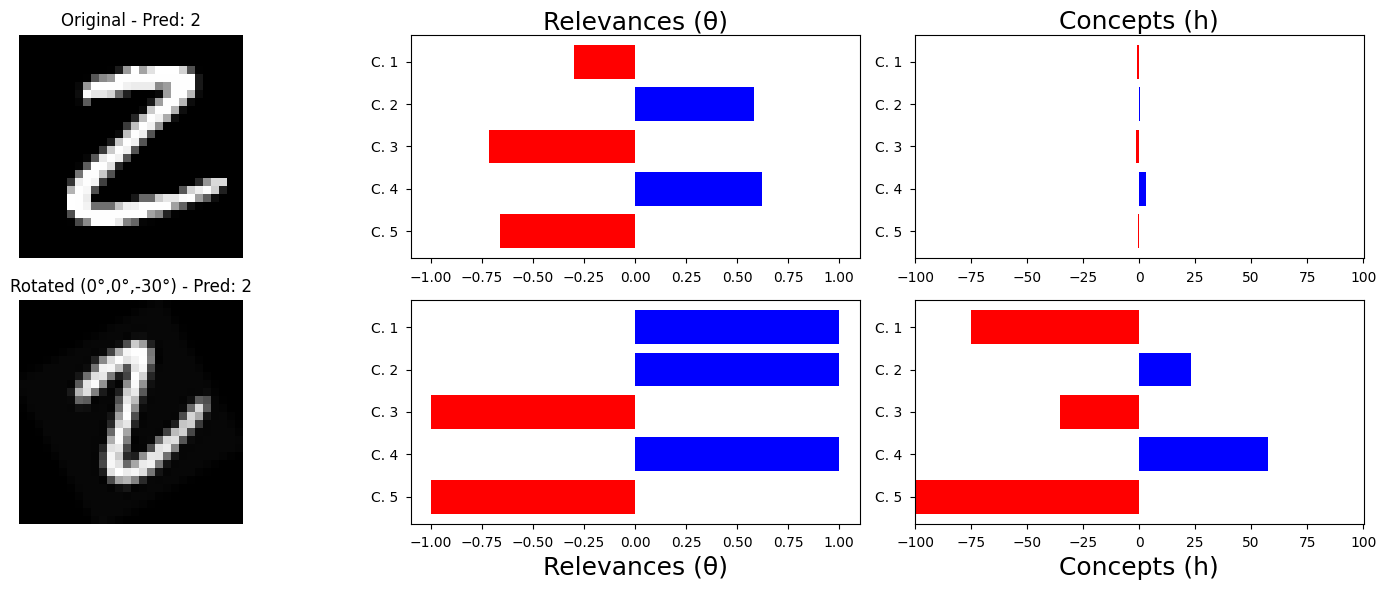


Z-Rotation Example 3/5 (angle: -17°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


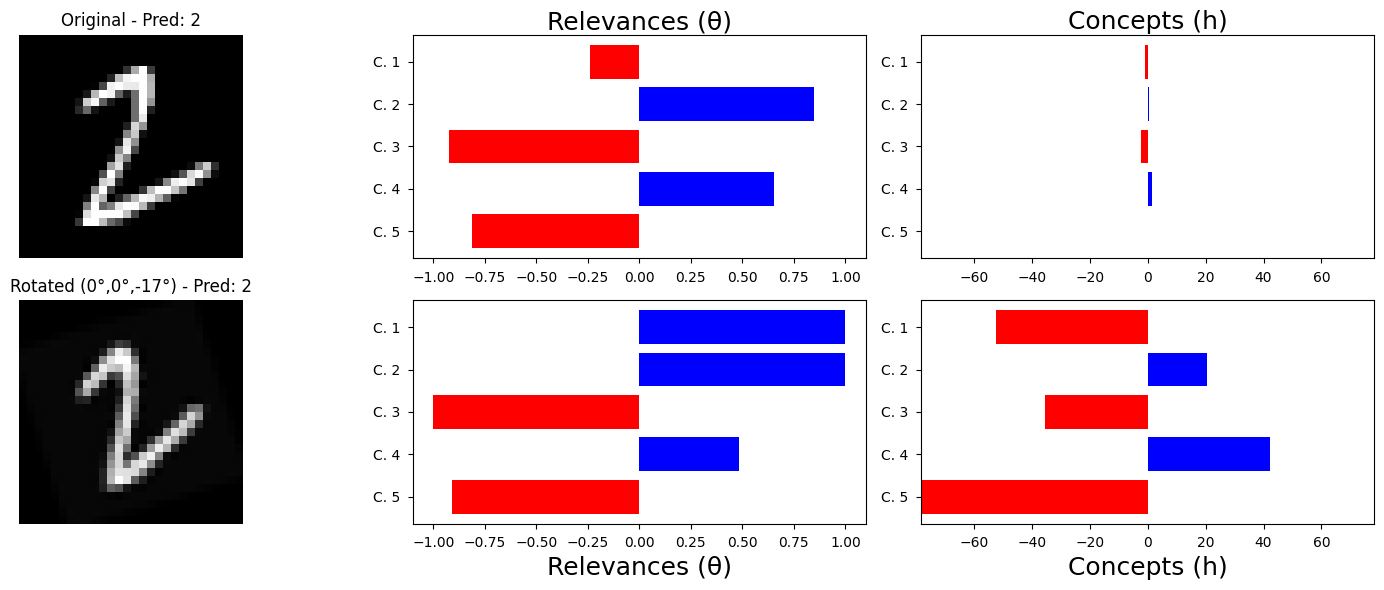


Z-Rotation Example 4/5 (angle: 25°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


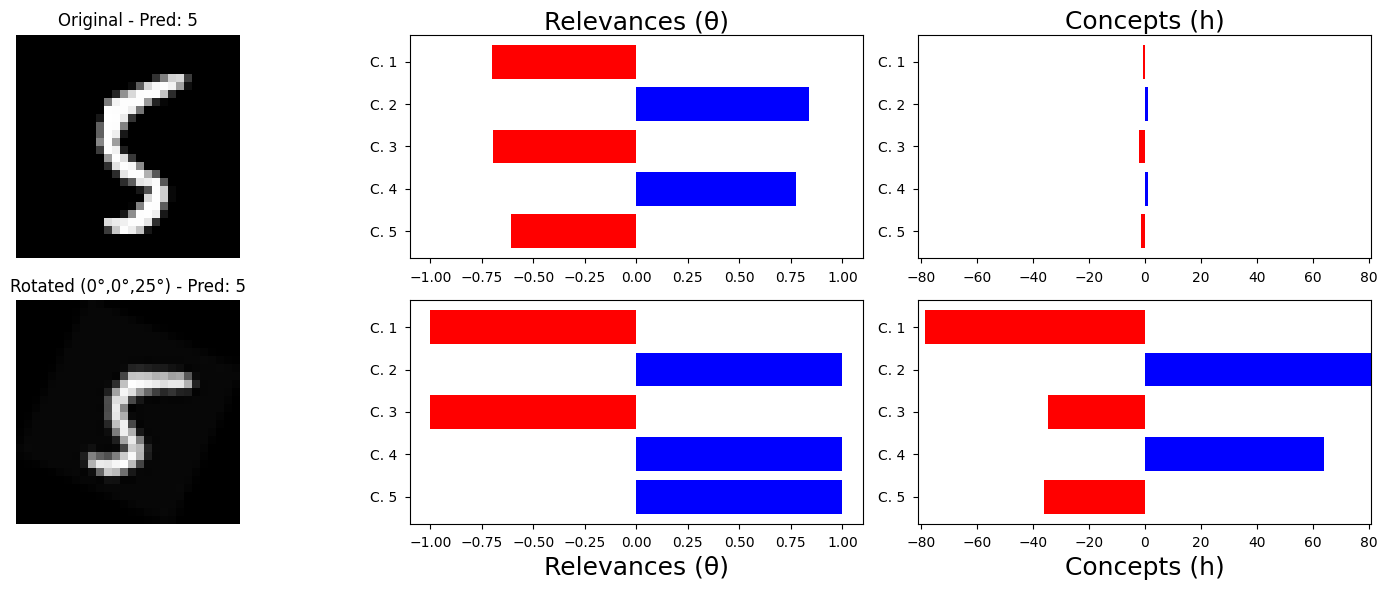


Z-Rotation Example 5/5 (angle: -30°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


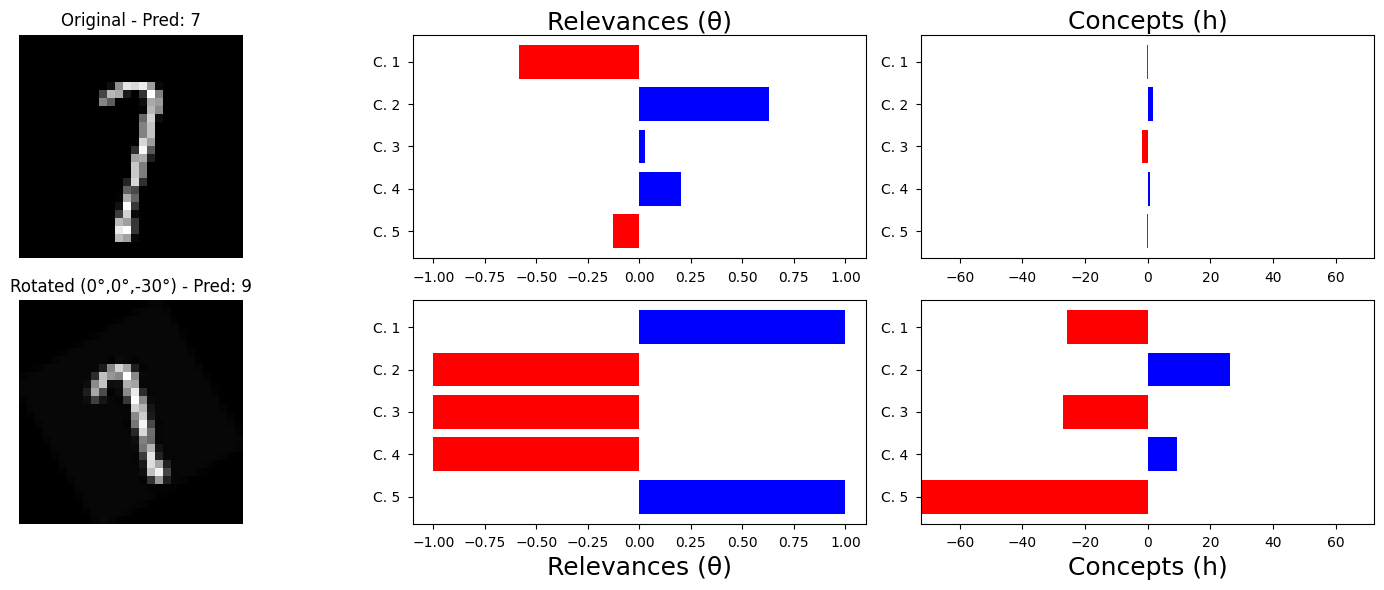


Moderate Rotations
--------------------------------------------------

X-Axis Rotations

X-Rotation Example 1/5 (angle: -32°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


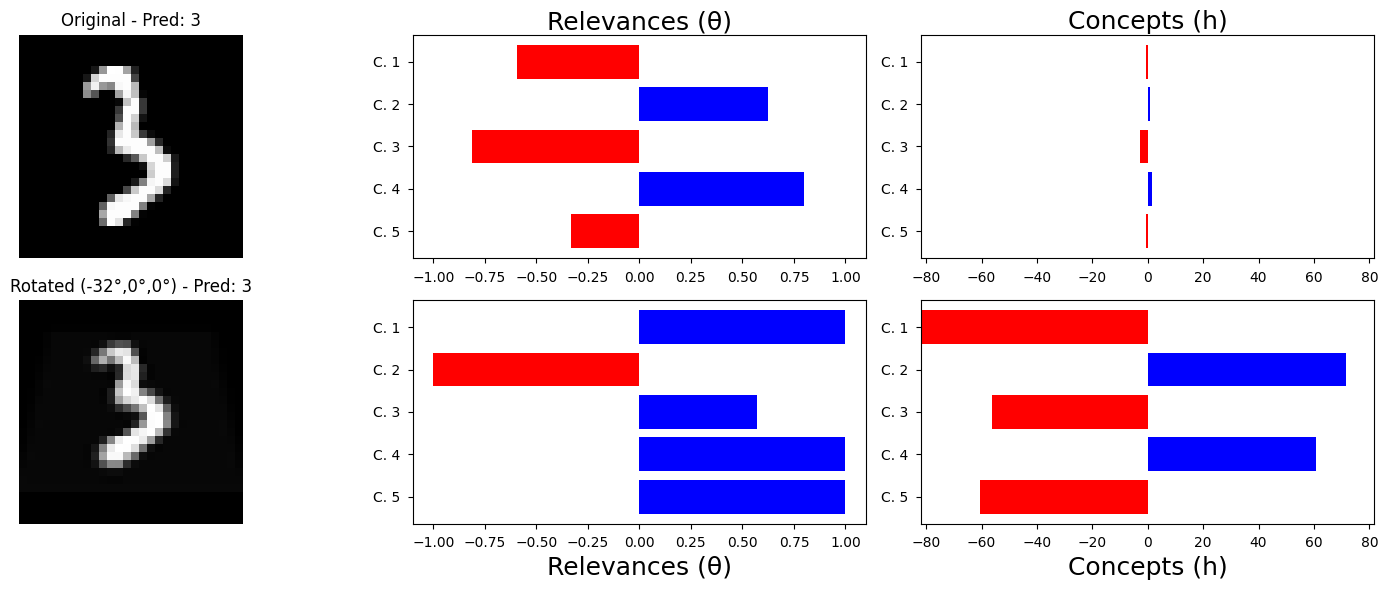


X-Rotation Example 2/5 (angle: 57°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


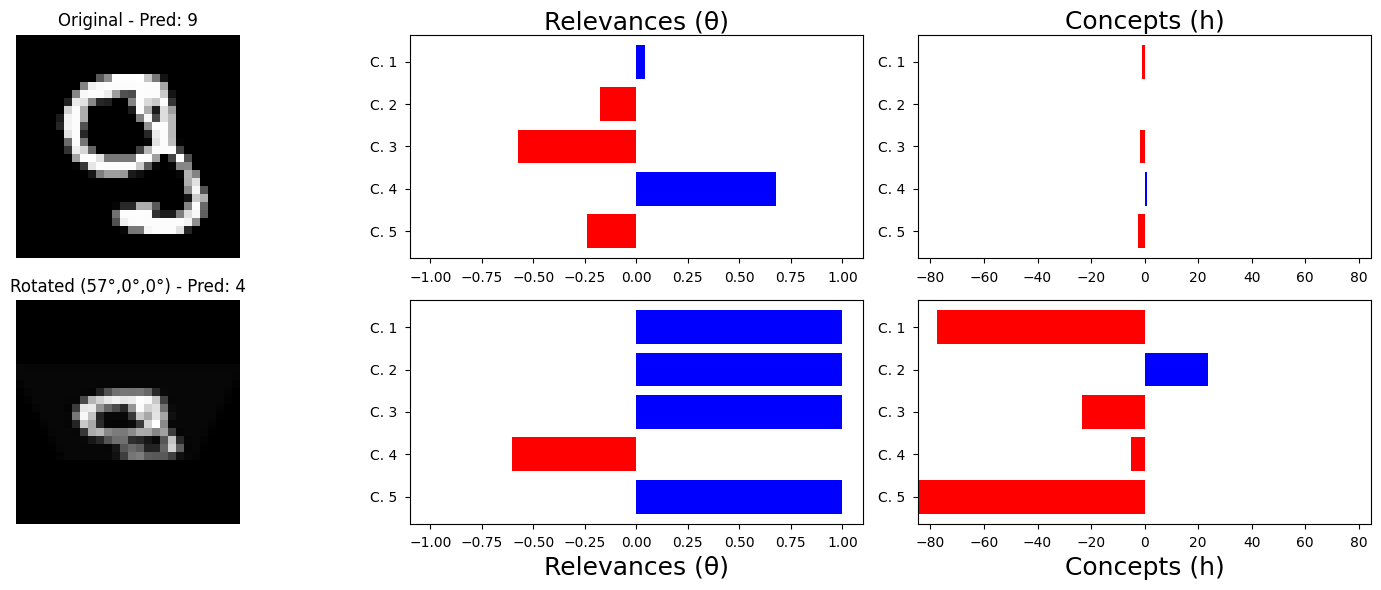


X-Rotation Example 3/5 (angle: -53°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


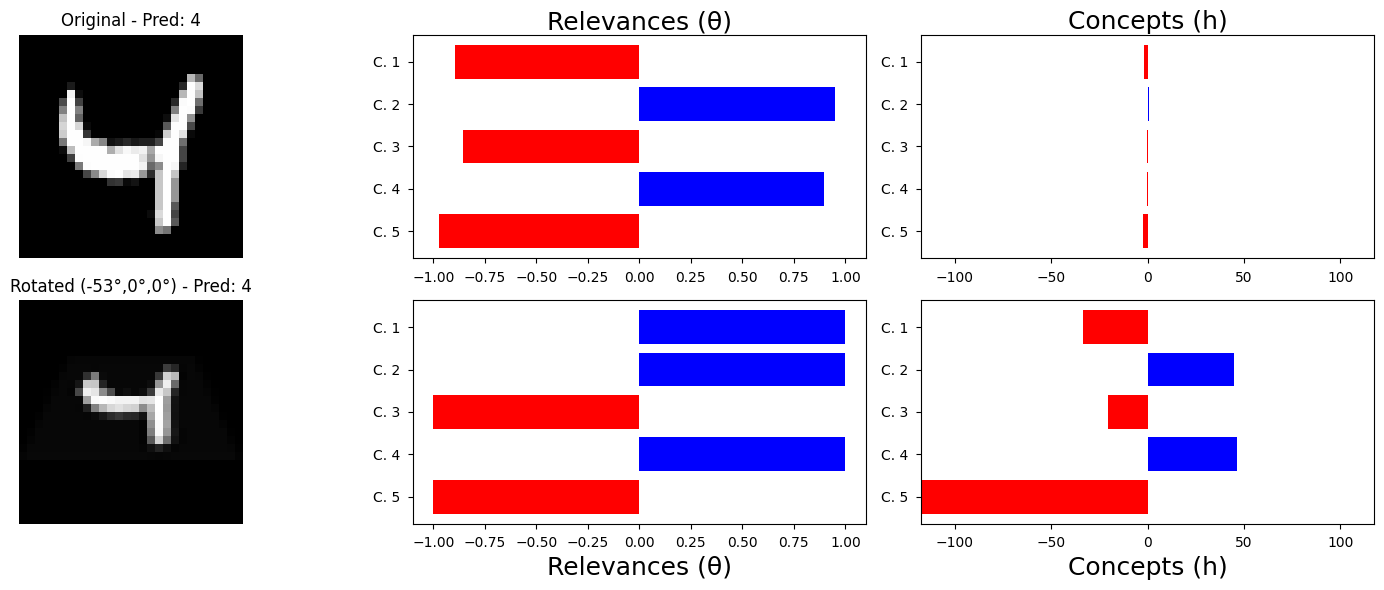


X-Rotation Example 4/5 (angle: -36°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


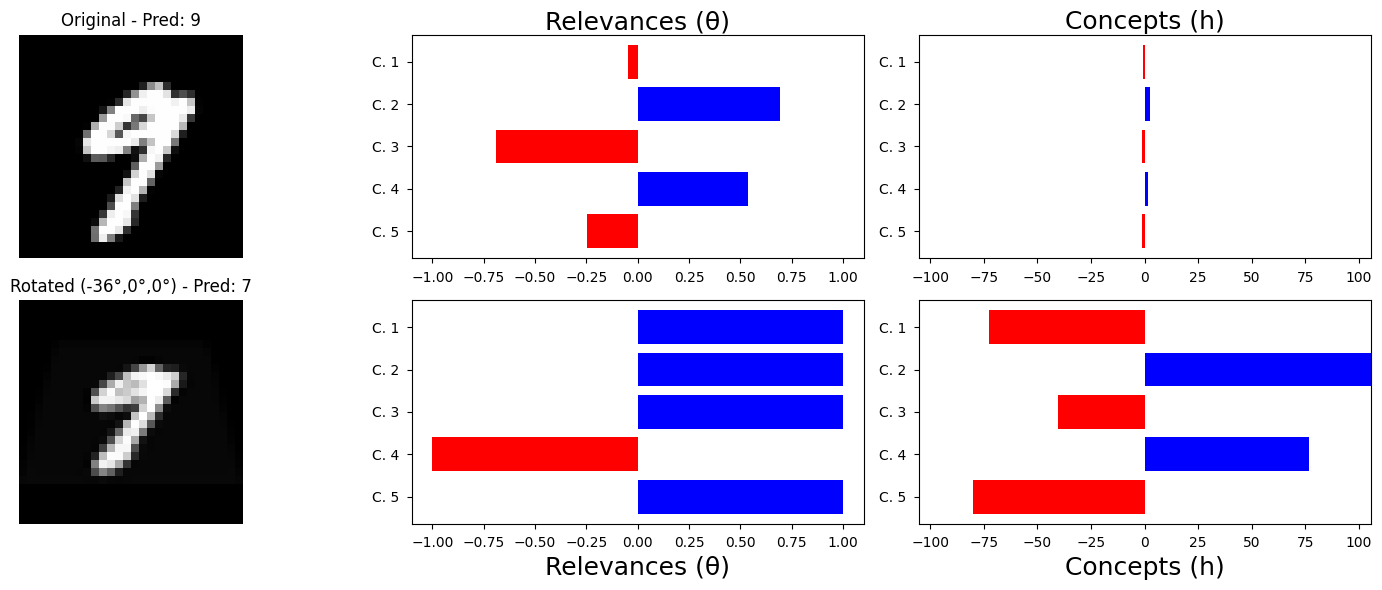


X-Rotation Example 5/5 (angle: -50°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


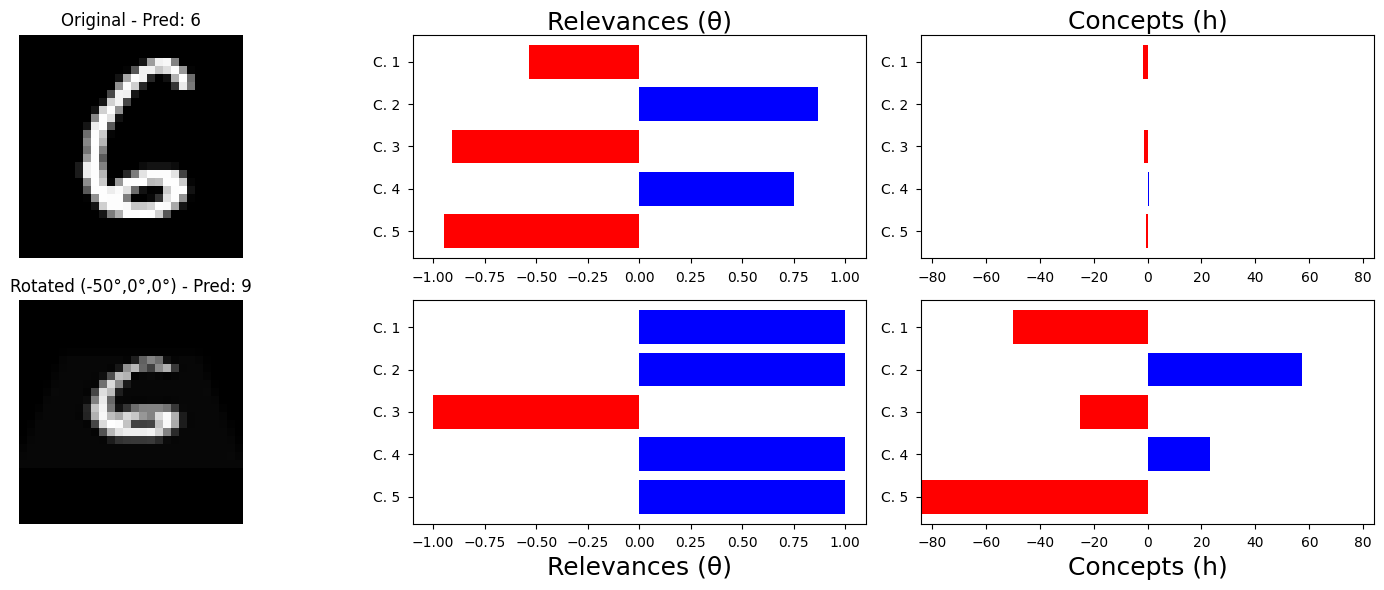


Y-Axis Rotations

Y-Rotation Example 1/5 (angle: 59°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


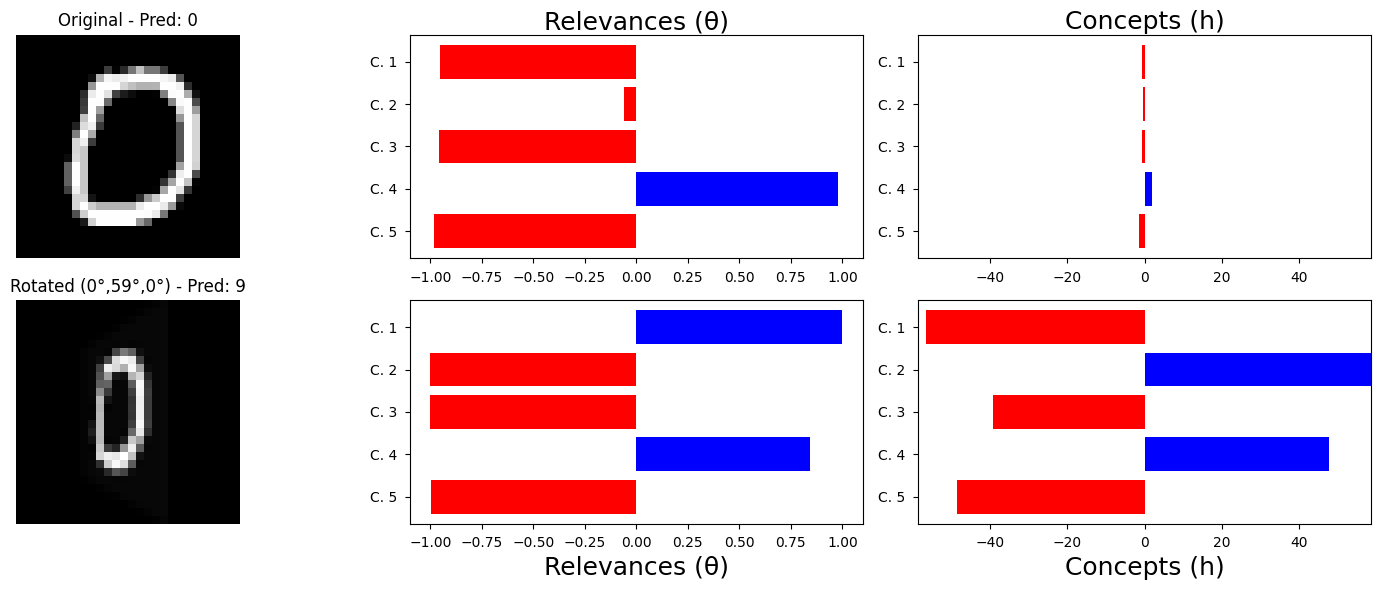


Y-Rotation Example 2/5 (angle: -60°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


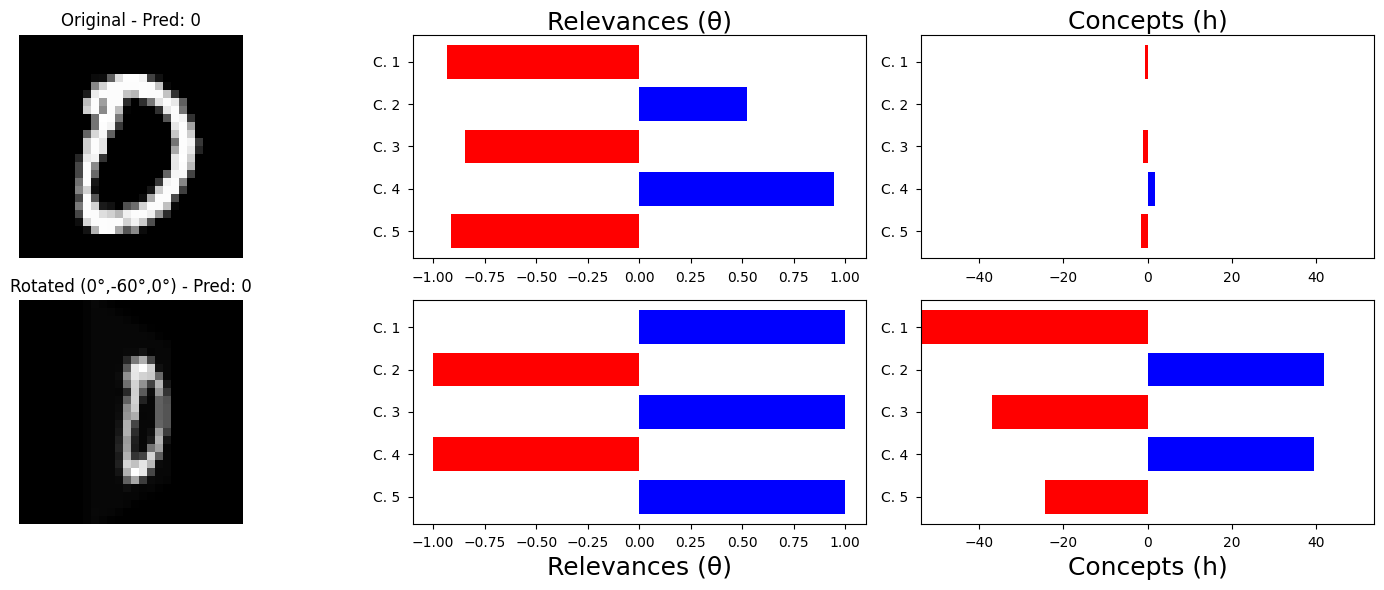


Y-Rotation Example 3/5 (angle: 34°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


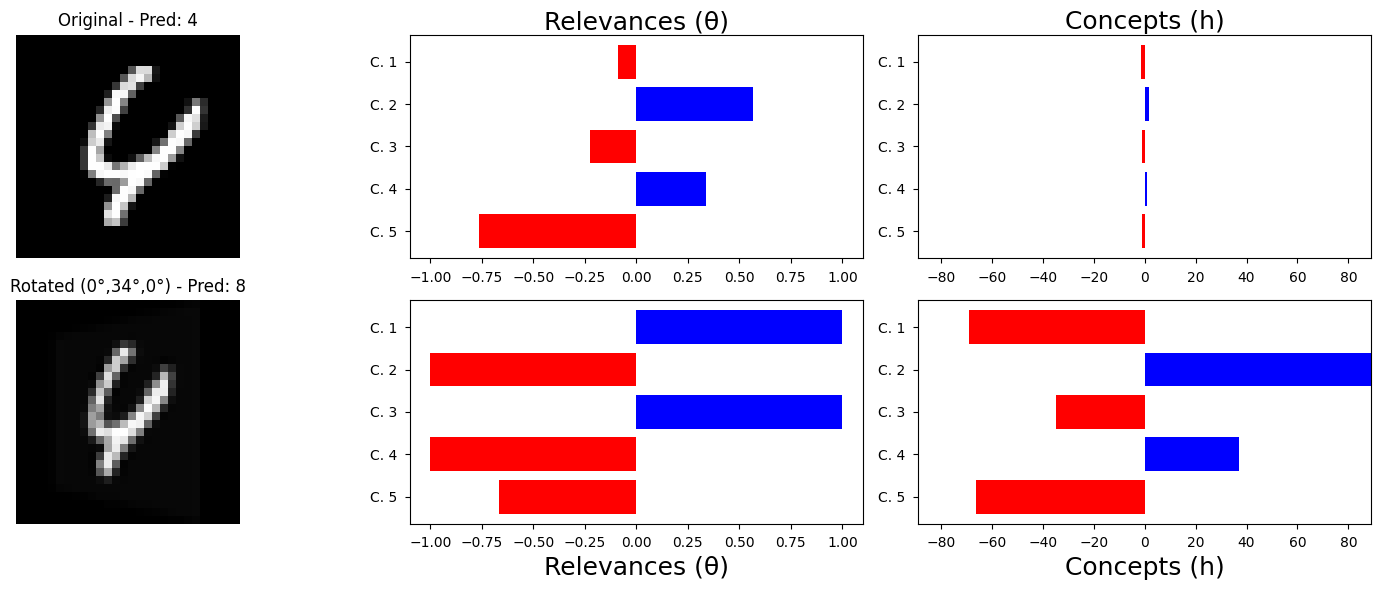


Y-Rotation Example 4/5 (angle: -35°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


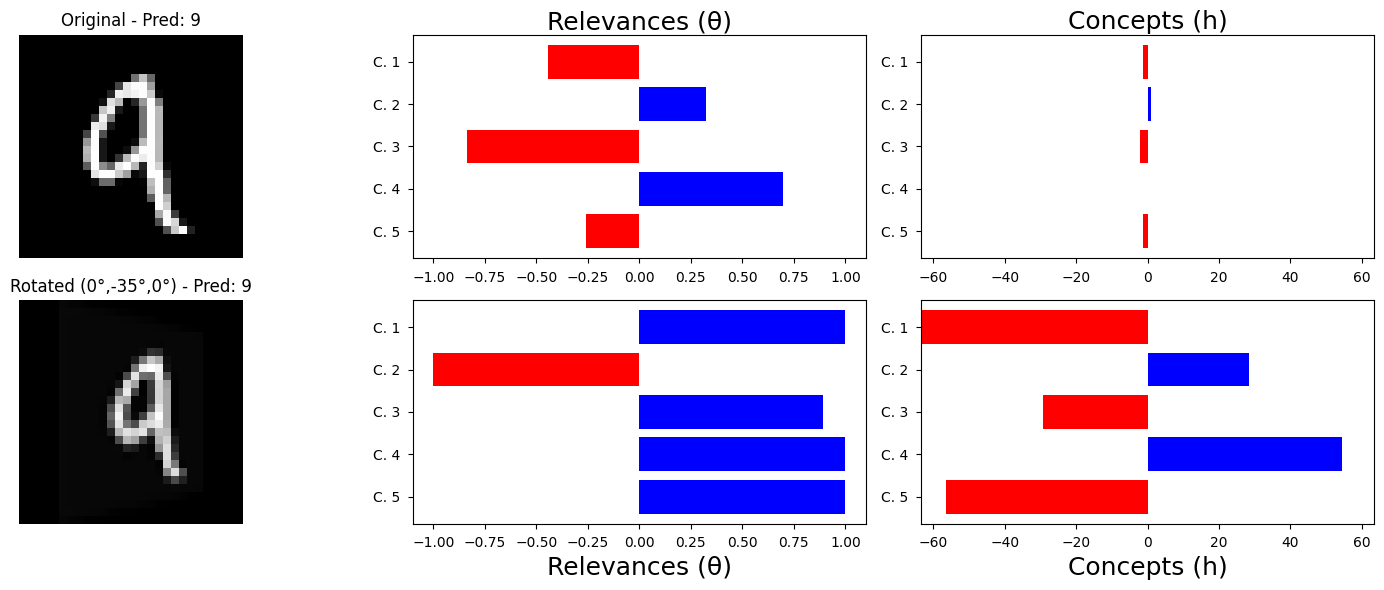


Y-Rotation Example 5/5 (angle: -49°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


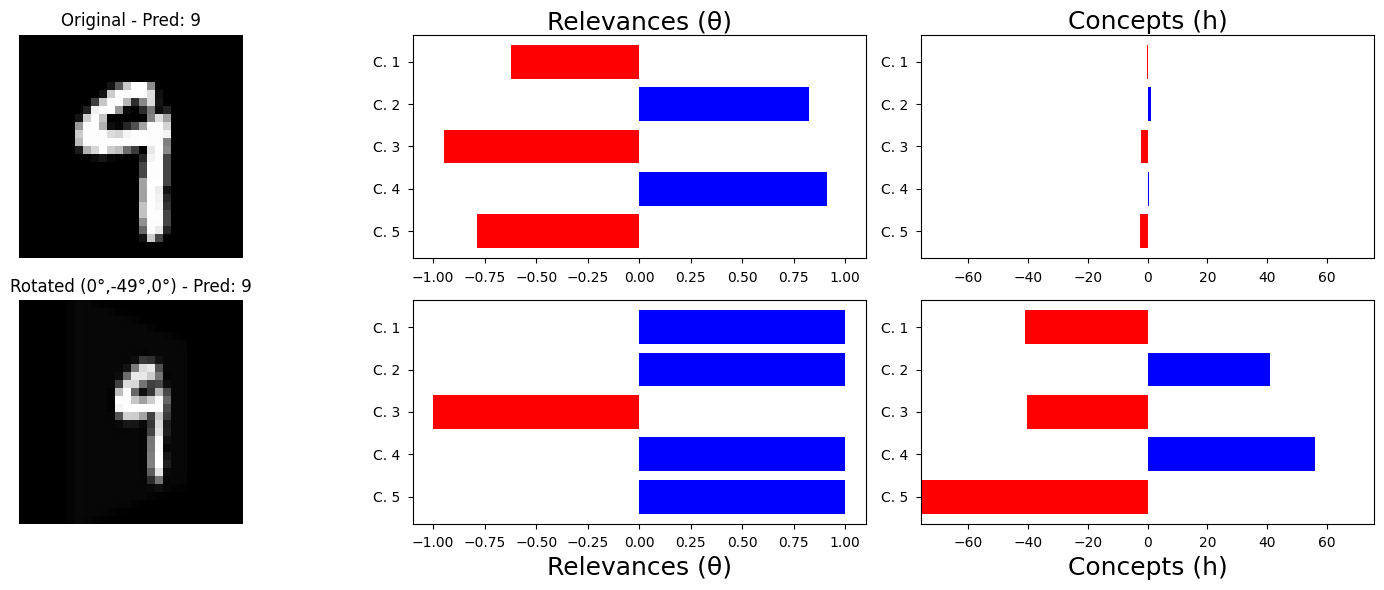


Z-Axis Rotations

Z-Rotation Example 1/5 (angle: -57°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


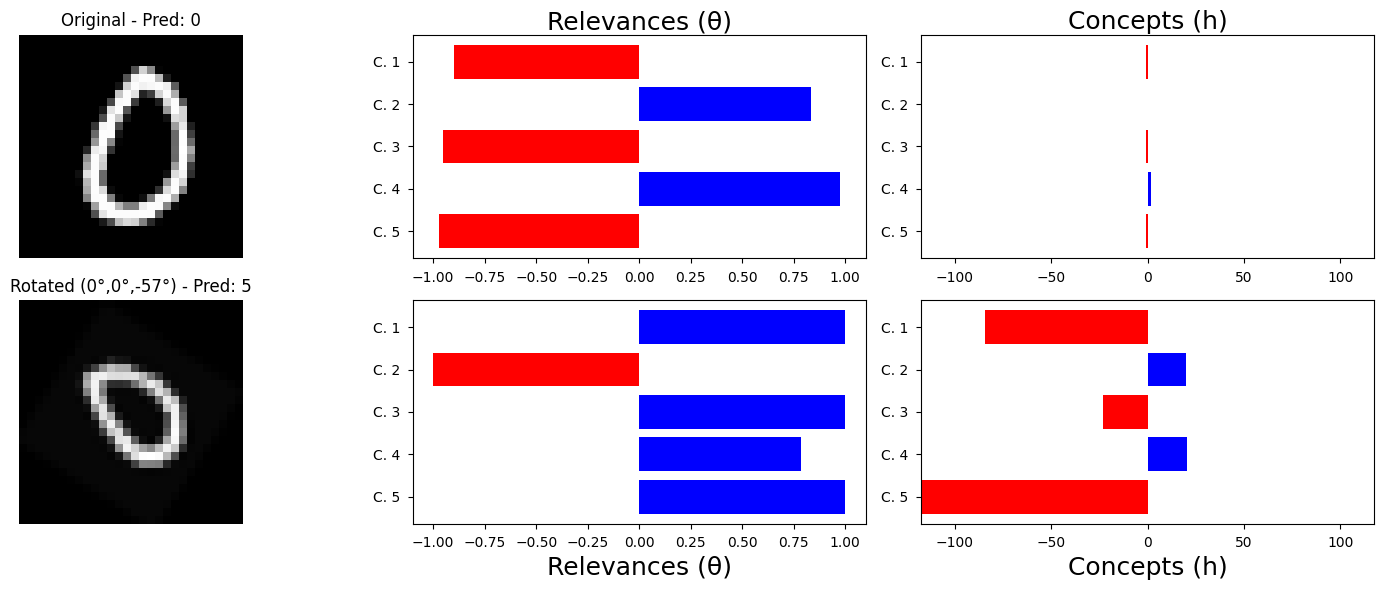


Z-Rotation Example 2/5 (angle: 33°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


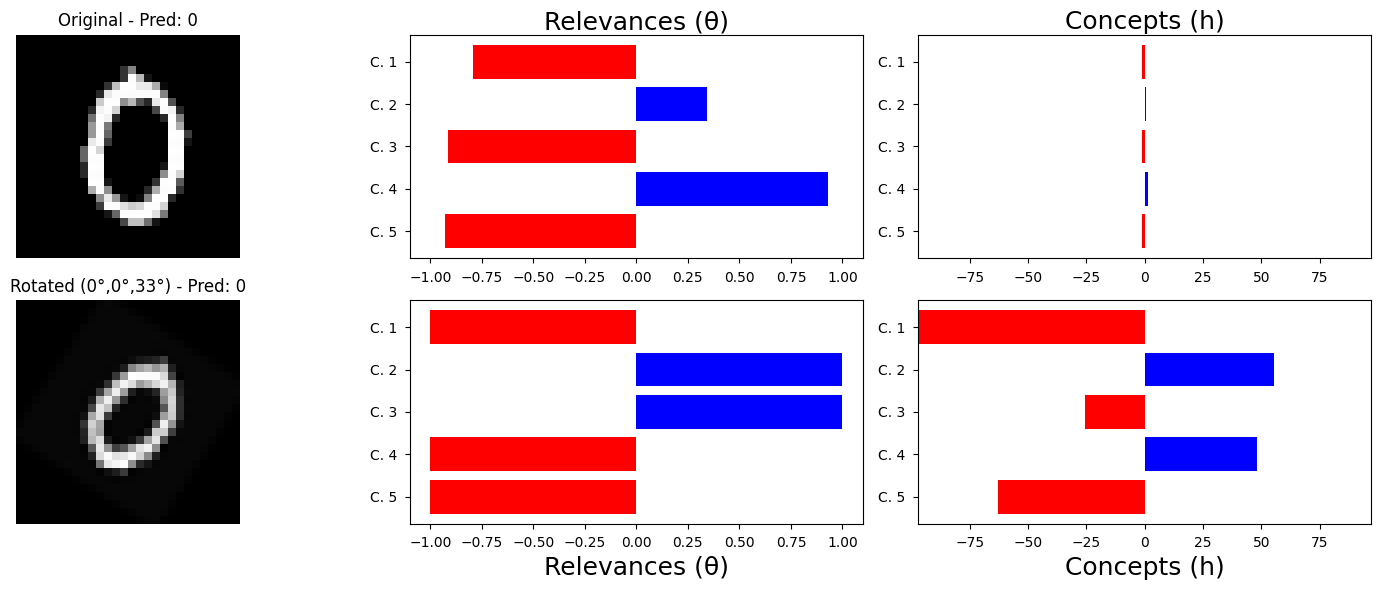


Z-Rotation Example 3/5 (angle: -32°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


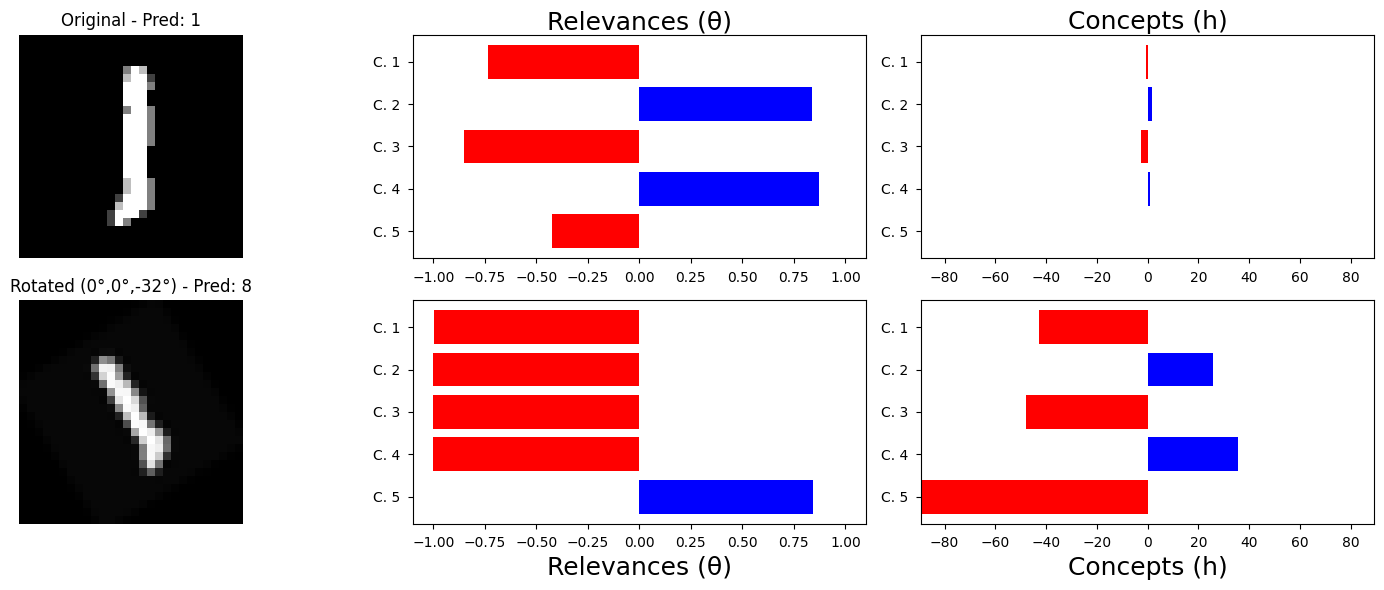


Z-Rotation Example 4/5 (angle: -60°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


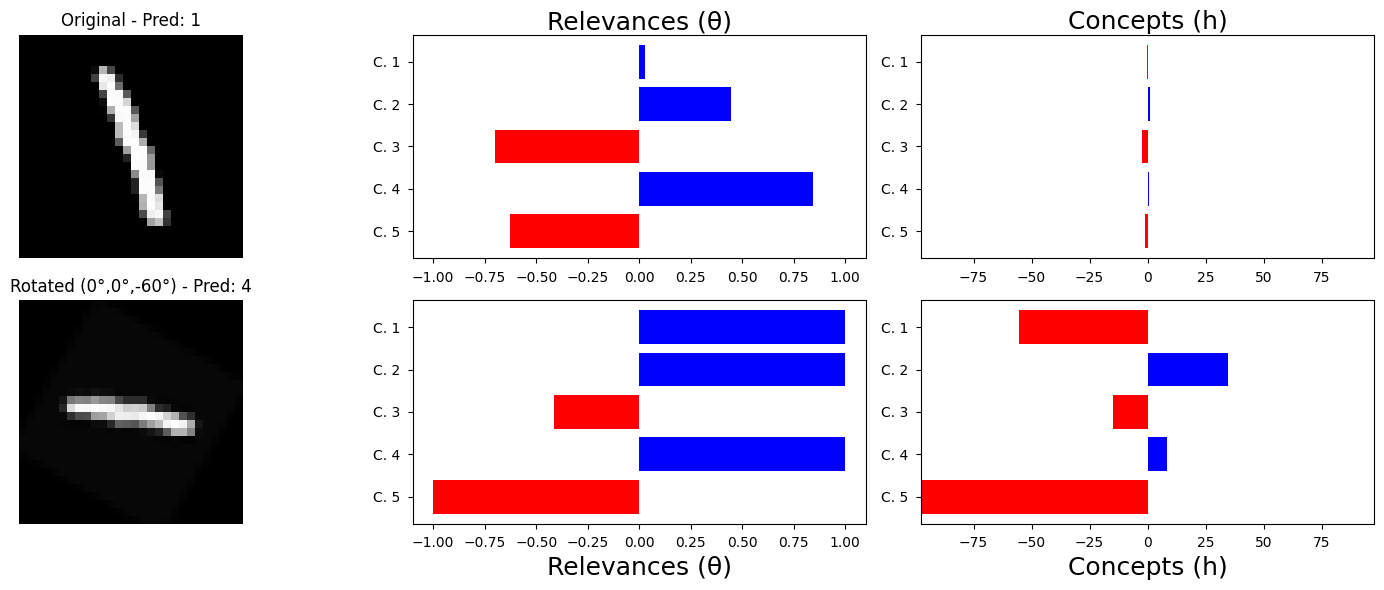


Z-Rotation Example 5/5 (angle: -59°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


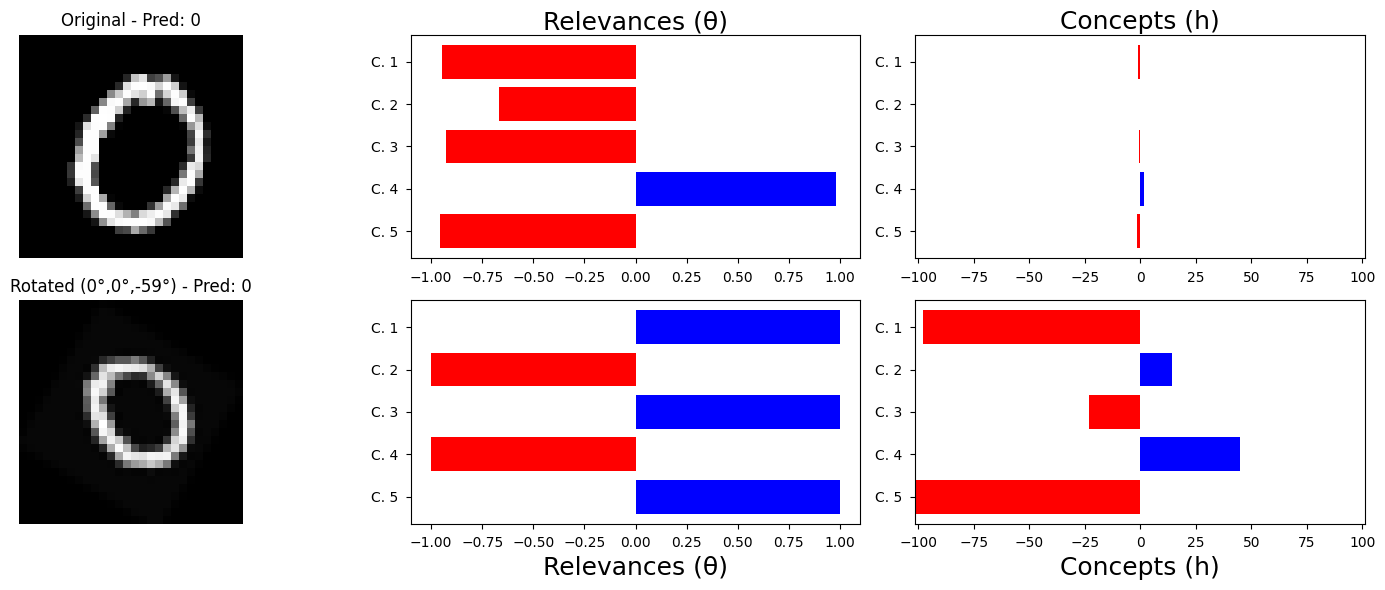


Extreme Rotations
--------------------------------------------------

X-Axis Rotations

X-Rotation Example 1/5 (angle: -65°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


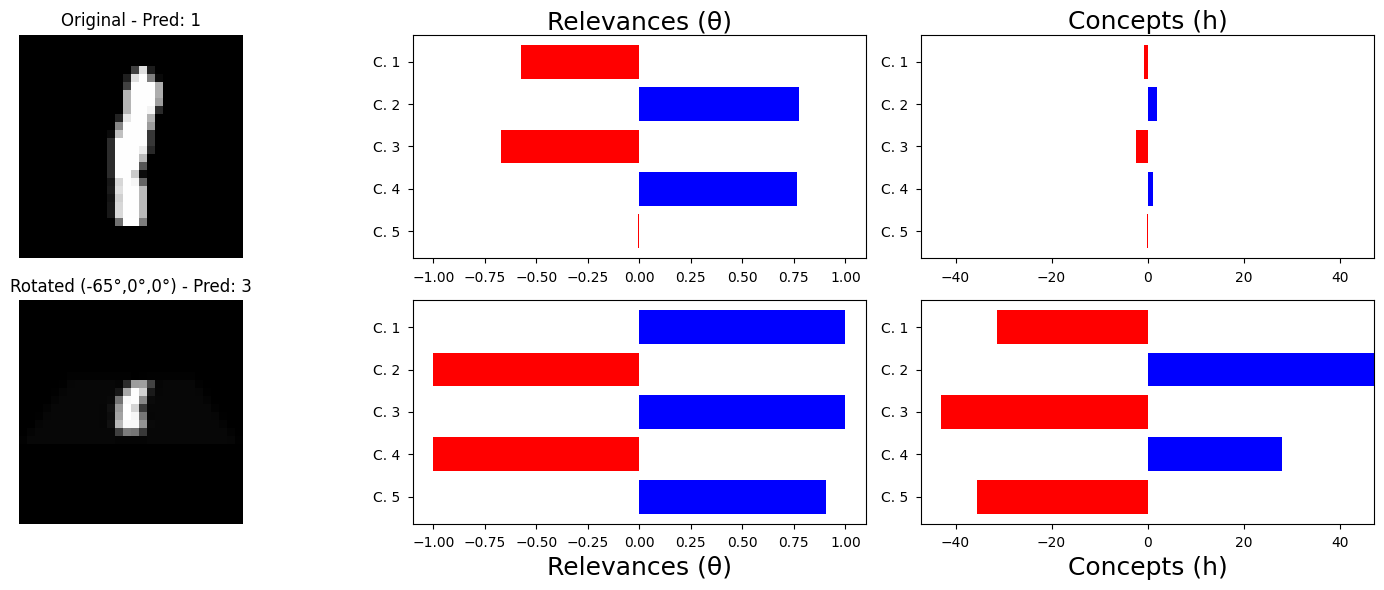


X-Rotation Example 2/5 (angle: -71°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


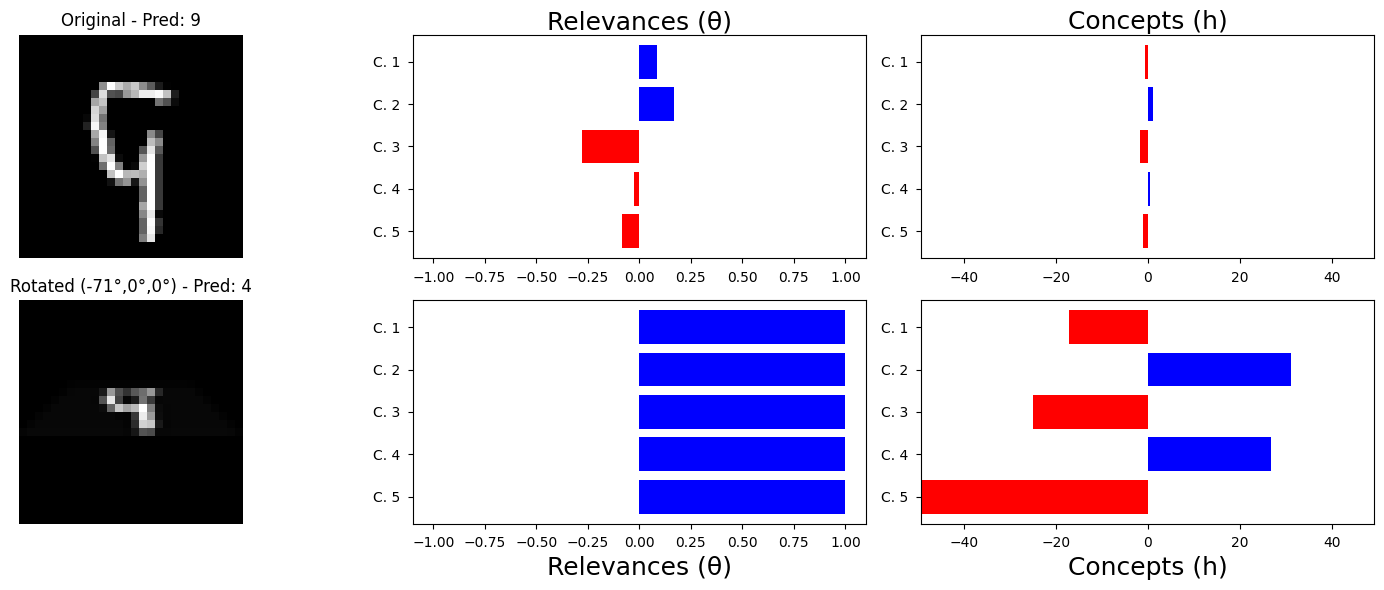


X-Rotation Example 3/5 (angle: 76°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.808758497238159
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.808758497238159
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.808758497238159


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


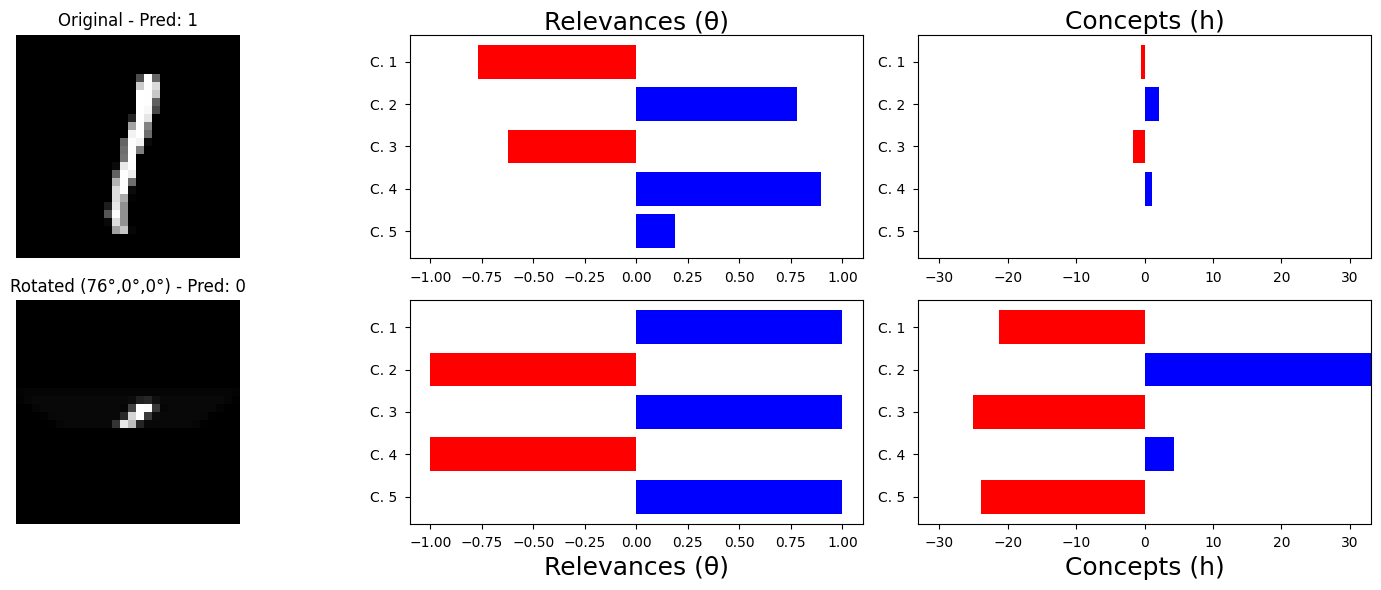


X-Rotation Example 4/5 (angle: -68°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


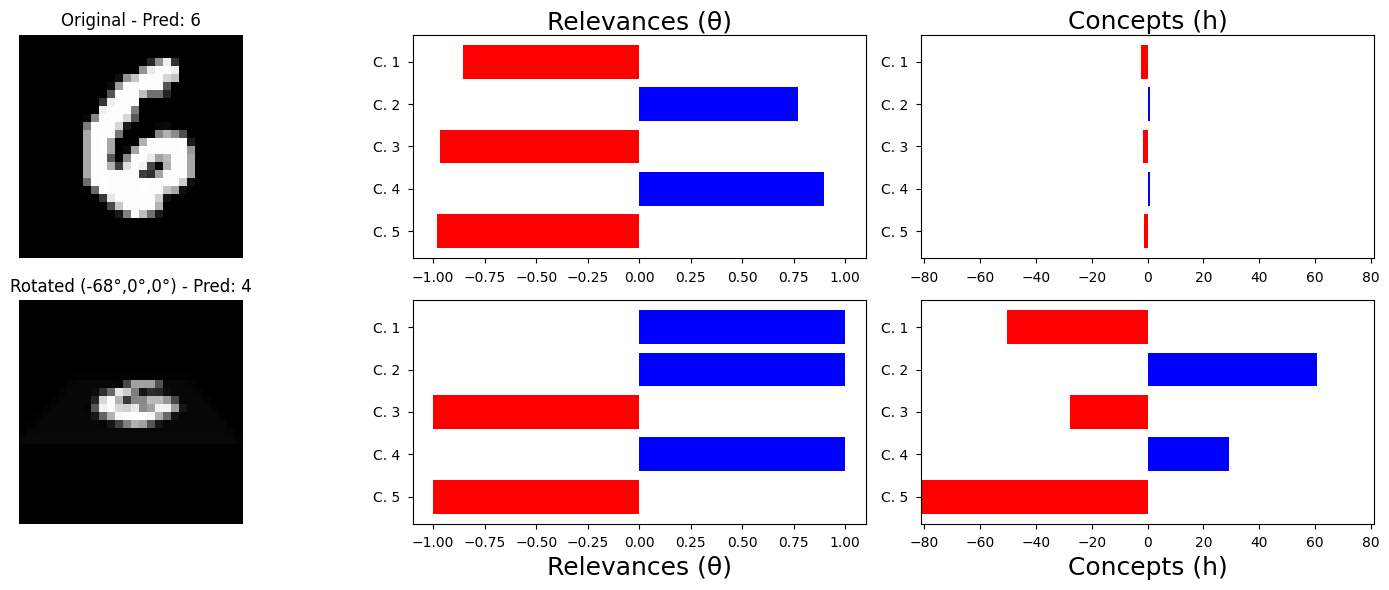


X-Rotation Example 5/5 (angle: -77°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


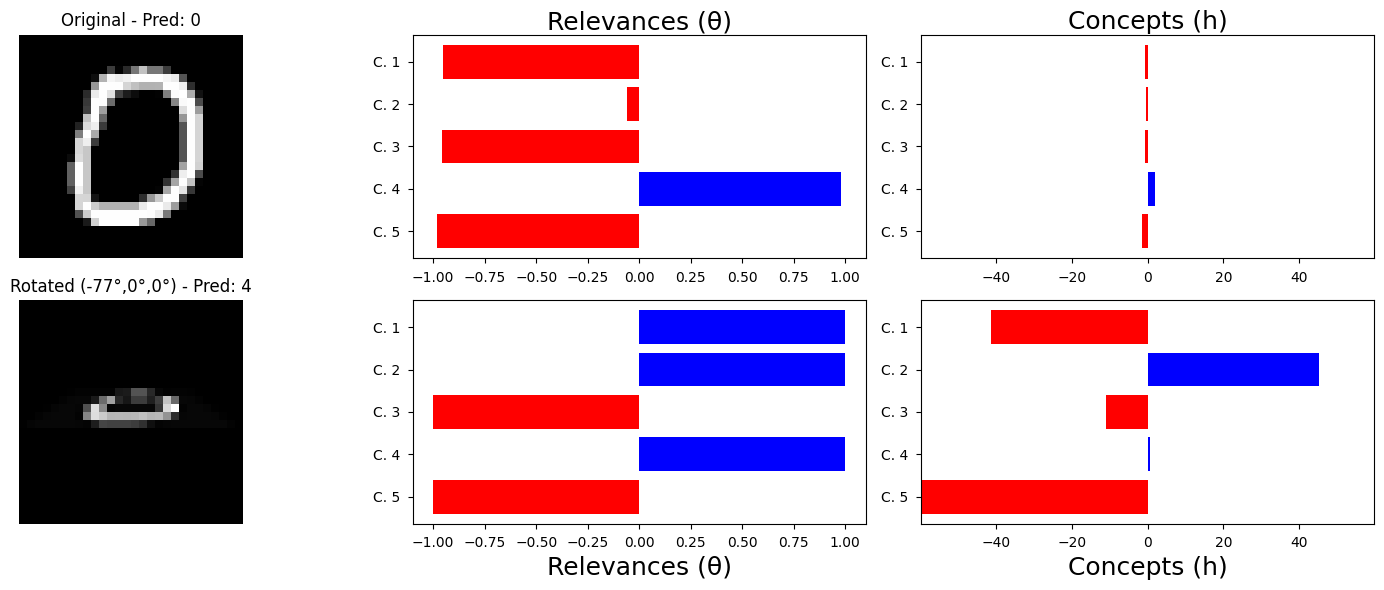


Y-Axis Rotations

Y-Rotation Example 1/5 (angle: 62°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


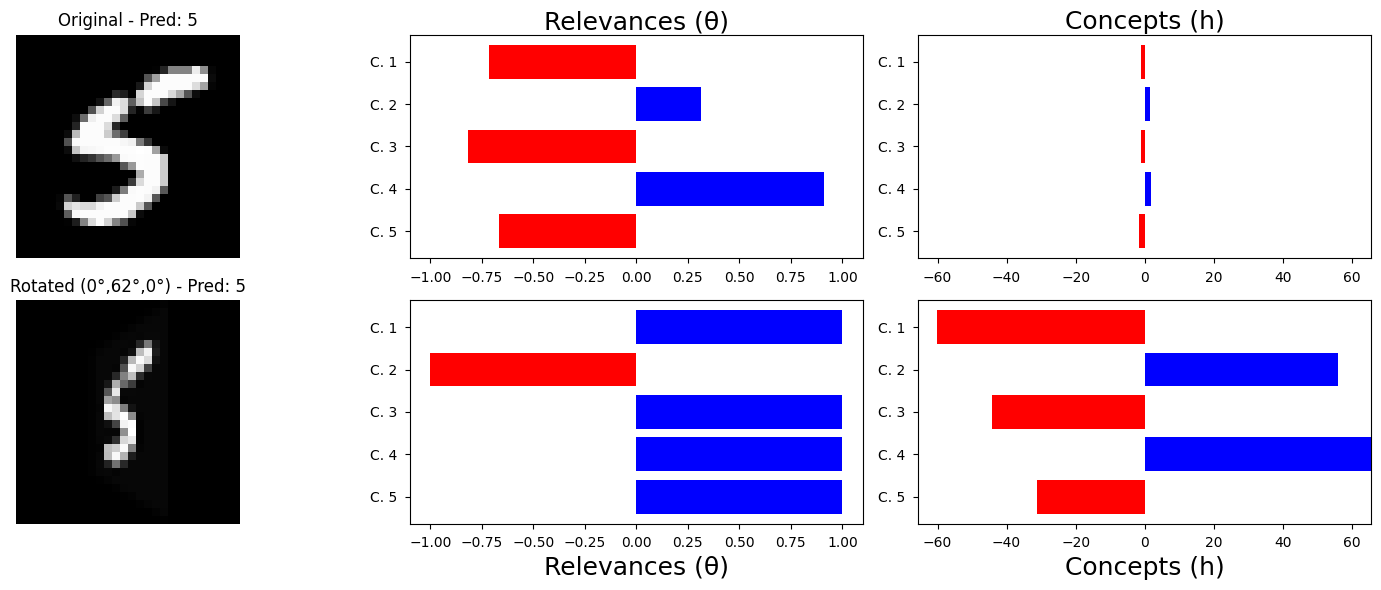


Y-Rotation Example 2/5 (angle: -82°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


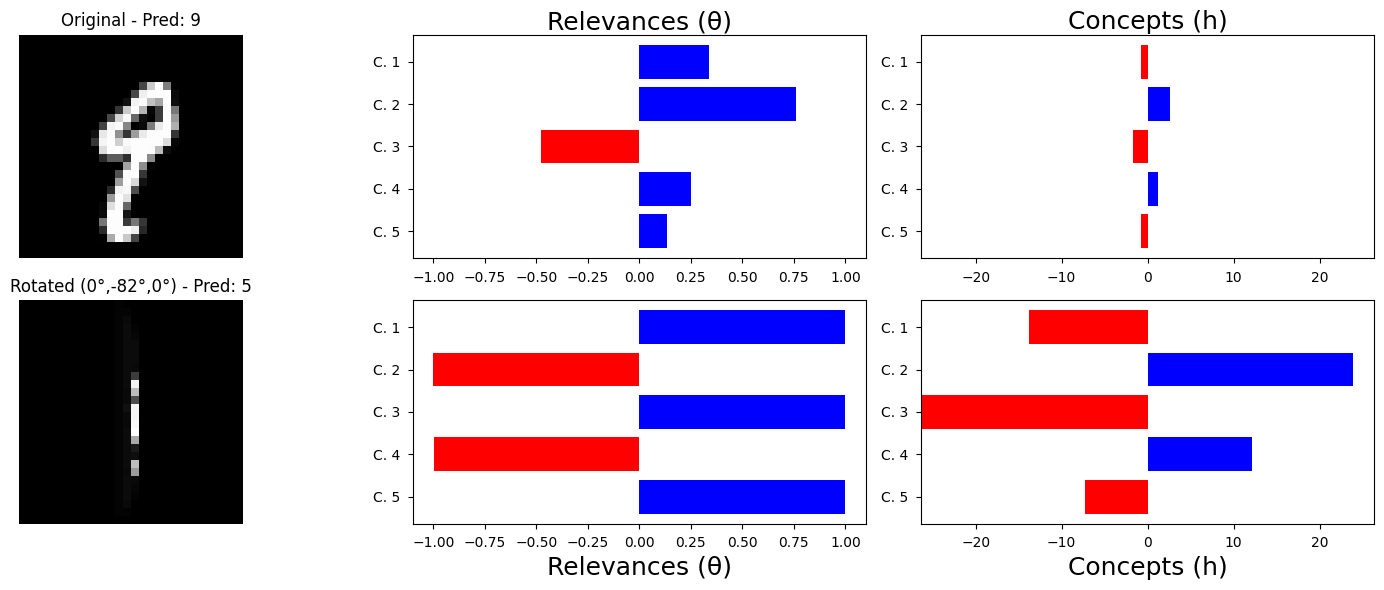


Y-Rotation Example 3/5 (angle: -81°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


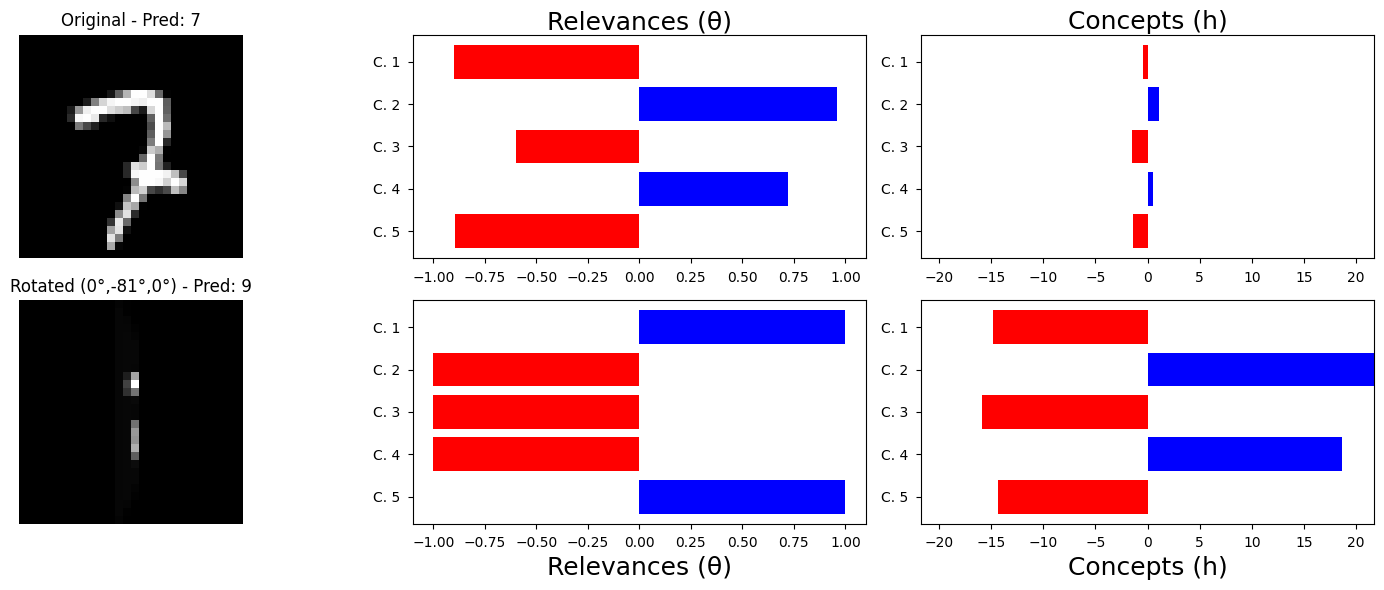


Y-Rotation Example 4/5 (angle: -82°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


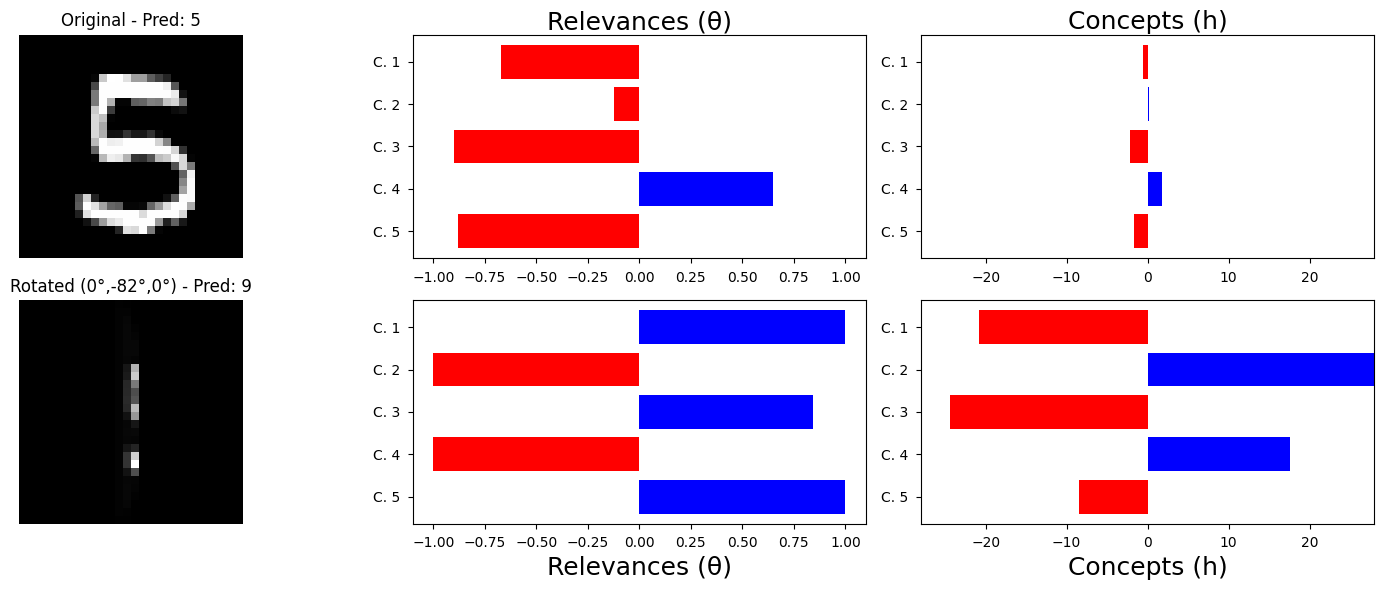


Y-Rotation Example 5/5 (angle: 68°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


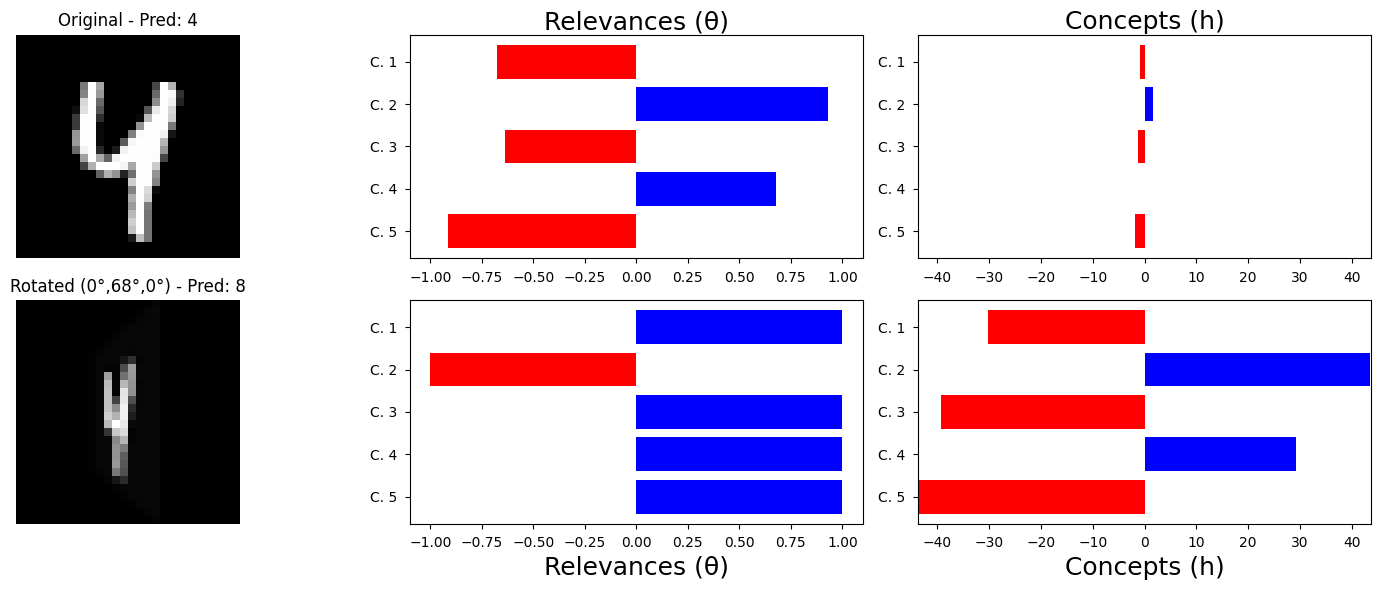


Z-Axis Rotations

Z-Rotation Example 1/5 (angle: 65°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


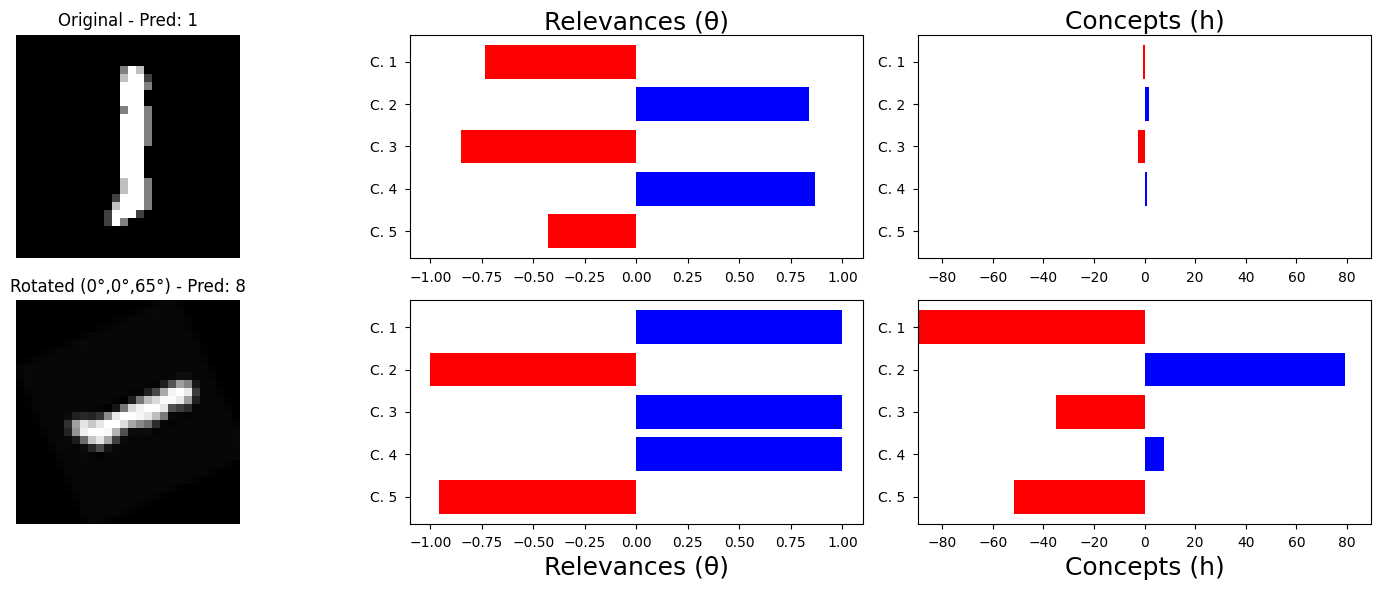


Z-Rotation Example 2/5 (angle: 82°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


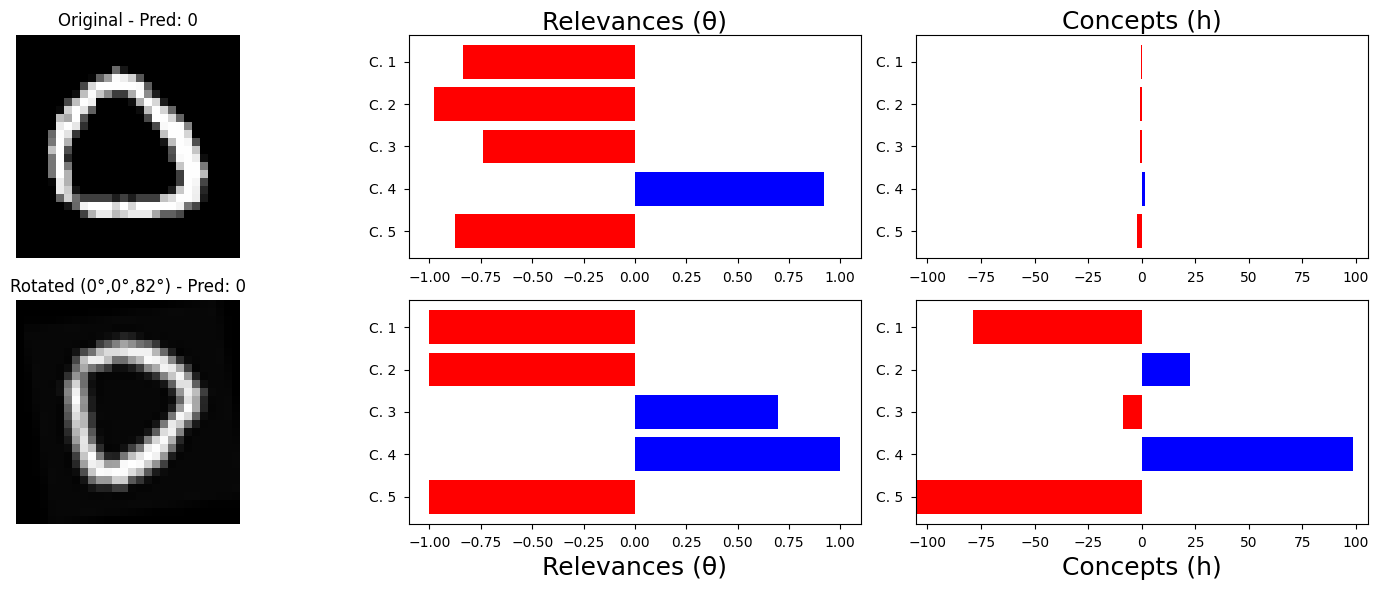


Z-Rotation Example 3/5 (angle: 73°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.808758497238159
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.808758497238159
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.808758497238159


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


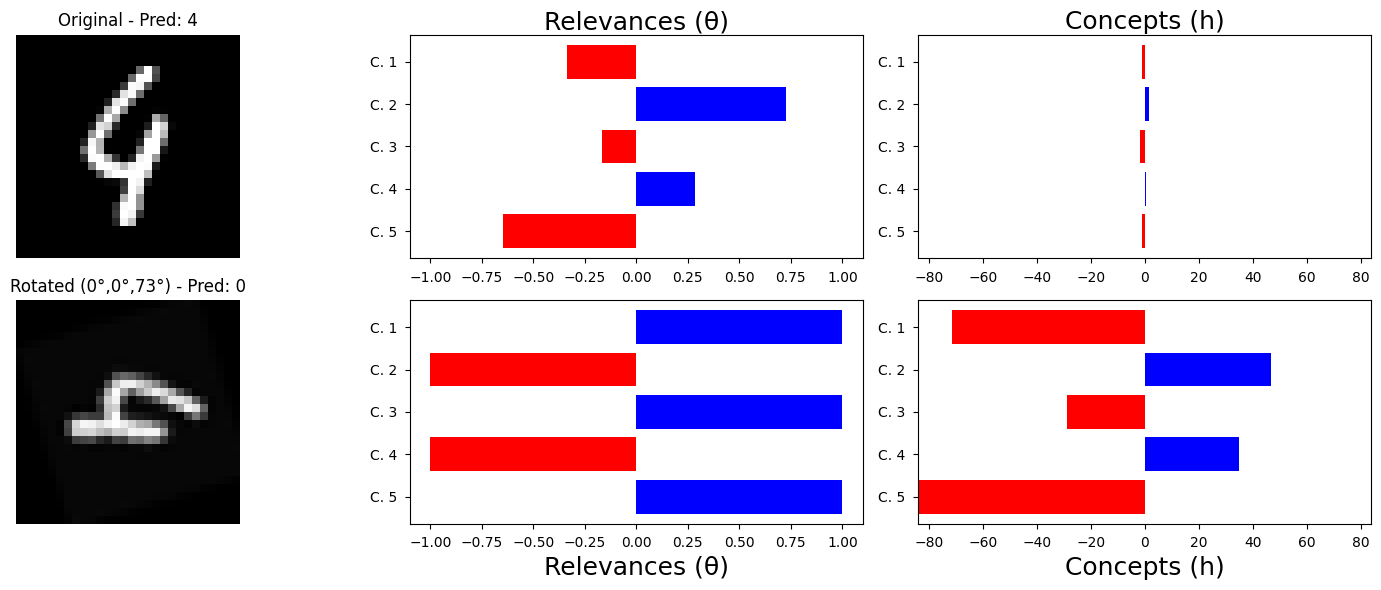


Z-Rotation Example 4/5 (angle: -62°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


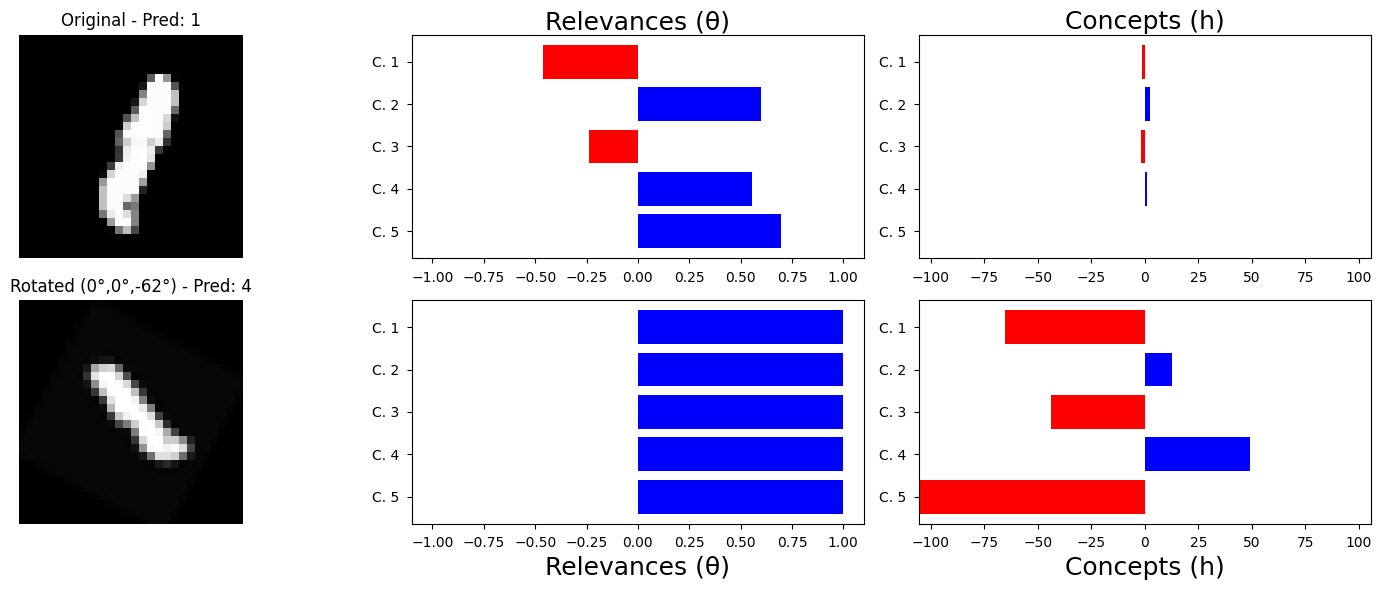


Z-Rotation Example 5/5 (angle: 82°)
Original image dtype: torch.float32
Original image range: -0.4242129623889923-2.821486711502075
After numpy conversion dtype: float32
Numpy range: -0.4242129623889923-2.821486711502075
After BGR merge dtype: float32
BGR range: -0.4242129623889923-2.821486711502075


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


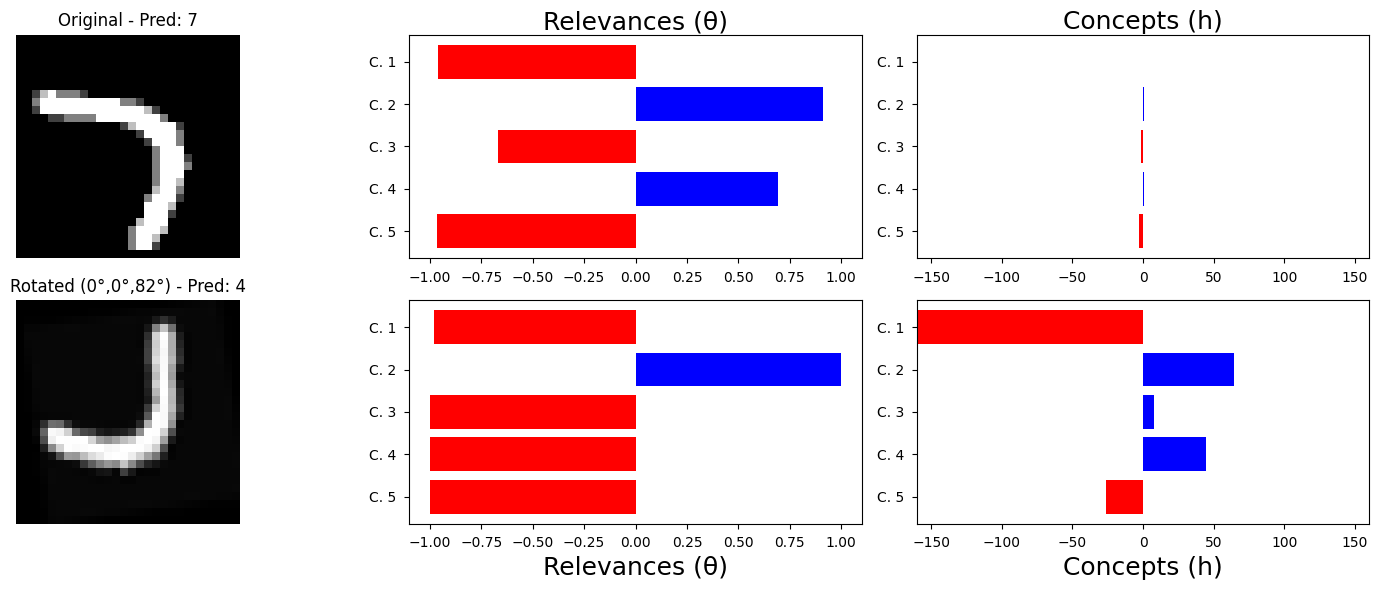

In [15]:
# Define rotation ranges
minor_range = (-30, 30)  # Single tuple for minor
moderate_ranges = [(-60, -31), (31, 60)]  # List of tuples for moderate
extreme_ranges = [(-85, -61), (61, 85)]  # List of tuples for moderate

def get_random_angle(angle_range):
    """Get random angle from either a single range tuple or list of range tuples"""
    if isinstance(angle_range[0], tuple):  # Multiple ranges (moderate/extreme)
        selected_range = random.choice(angle_range)
        return np.random.randint(selected_range[0], selected_range[1])
    else:  # Single range (minor)
        return np.random.randint(angle_range[0], angle_range[1])

# Example usage in your loop:
for severity, ranges in [
    ("Minor", minor_range),
    ("Moderate", moderate_ranges),
    ("Extreme", extreme_ranges)
]:
    print(f"\n{severity} Rotations")
    print("-" * 50)
    
    # For each axis (X, Y, Z)
    for axis in ["X", "Y", "Z"]:
        print(f"\n{axis}-Axis Rotations")
        for i in range(5):
            test_batch, _ = next(iter(mnist_test_dl))
            random_idx = np.random.randint(0, len(test_batch))
            sample_image = test_batch[random_idx]
            
            angle = get_random_angle(ranges)
            print(f"\n{axis}-Rotation Example {i+1}/5 (angle: {angle}°)")
            
            rotation_args = {
                f"{axis.lower()}_rotation": angle
            }
            show_explanation_with_rotation(
                model=mnist_SENN,
                image=sample_image,
                **rotation_args
            )